Importing the required Python Libraries for this stage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

Reading the long format Superset dataset from stage-2

In [3]:
superset_long = pd.read_csv("../../../../data/stage_2/superset_long.csv")

In [4]:
superset_long

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases
0,1001,AL,Autauga County,1,55869,1/22/2020,0,0
1,1003,AL,Baldwin County,1,223234,1/22/2020,0,0
2,1005,AL,Barbour County,1,24686,1/22/2020,0,0
3,1007,AL,Bibb County,1,22394,1/22/2020,0,0
4,1009,AL,Blount County,1,57826,1/22/2020,0,0
...,...,...,...,...,...,...,...,...
1800361,56037,WY,Sweetwater County,56,42343,8/16/2021,45,5127
1800362,56039,WY,Teton County,56,23464,8/16/2021,11,4068
1800363,56041,WY,Uinta County,56,20226,8/16/2021,14,2593
1800364,56043,WY,Washakie County,56,7805,8/16/2021,26,967


Collecting the data of Indiana State

In [5]:
Indiana_df=superset_long[superset_long['StateFIPS']==18]
Indiana_df

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases
697,18001,IN,Adams County,18,35777,1/22/2020,0,0
698,18003,IN,Allen County,18,379299,1/22/2020,0,0
699,18005,IN,Bartholomew County,18,83779,1/22/2020,0,0
700,18007,IN,Benton County,18,8748,1/22/2020,0,0
701,18009,IN,Blackford County,18,11758,1/22/2020,0,0
...,...,...,...,...,...,...,...,...
1798008,18175,IN,Washington County,18,28036,8/16/2021,40,2682
1798009,18177,IN,Wayne County,18,65884,8/16/2021,206,7869
1798010,18179,IN,Wells County,18,28296,8/16/2021,83,3218
1798011,18181,IN,White County,18,24102,8/16/2021,55,3488


Calculating the total cases and deaths of Indiana State for a given date. Then considering the data from the first day of infection.

In [6]:
Indiana_df['Date'] = pd.to_datetime(Indiana_df['Date'])
Indiana_State = Indiana_df.groupby(['Date']).sum().reset_index()
Indiana_State = Indiana_State[Indiana_State['Cases']>0]
Indiana_State

,Date,countyFIPS,StateFIPS,population,Deaths,Cases
44,2020-03-06,1664464,1656,6732219,0,1
45,2020-03-07,1664464,1656,6732219,0,1
46,2020-03-08,1664464,1656,6732219,0,2
47,2020-03-09,1664464,1656,6732219,0,6
48,2020-03-10,1664464,1656,6732219,0,10
...,...,...,...,...,...,...
568,2021-08-12,1664464,1656,6732219,14116,797712
569,2021-08-13,1664464,1656,6732219,14128,800367
570,2021-08-14,1664464,1656,6732219,14128,800367
571,2021-08-15,1664464,1656,6732219,14128,800367


Finding new cases and deaths per day in Indaina state and converting the data type of those columns to integer

In [7]:
Indiana_State['IN_New_cases_per_day']  = Indiana_State.groupby('countyFIPS').Cases.diff()
Indiana_State['IN_New_deaths_per_day'] = Indiana_State.groupby('countyFIPS').Deaths.diff()
Indiana_State = Indiana_State.dropna()
Indiana_State['Date'] = pd.to_datetime(Indiana_State['Date'])
Indiana_State.IN_New_cases_per_day = Indiana_State.IN_New_cases_per_day.astype(int)
Indiana_State.IN_New_deaths_per_day = Indiana_State.IN_New_deaths_per_day.astype(int)

Converting the number of new cases and deaths to zero if there are any negative values.

In [8]:
Indiana_State['IN_Days_Count'] = 0
Indiana_State['IN_New_cases_per_day'][Indiana_State['IN_New_cases_per_day']<0]=0
Indiana_State['IN_New_deaths_per_day'][Indiana_State['IN_New_deaths_per_day']<0]=0
Indiana_State

,Date,countyFIPS,StateFIPS,population,Deaths,Cases,IN_New_cases_per_day,IN_New_deaths_per_day,IN_Days_Count
45,2020-03-07,1664464,1656,6732219,0,1,0,0,0
46,2020-03-08,1664464,1656,6732219,0,2,1,0,0
47,2020-03-09,1664464,1656,6732219,0,6,4,0,0
48,2020-03-10,1664464,1656,6732219,0,10,4,0,0
49,2020-03-11,1664464,1656,6732219,0,10,0,0,0
...,...,...,...,...,...,...,...,...,...
568,2021-08-12,1664464,1656,6732219,14116,797712,3152,6,0
569,2021-08-13,1664464,1656,6732219,14128,800367,2655,12,0
570,2021-08-14,1664464,1656,6732219,14128,800367,0,0,0
571,2021-08-15,1664464,1656,6732219,14128,800367,0,0,0


Counting number of days since first case in Indiana State and adding it to the dataframe

In [9]:
IN_DaysList=[]
for i in range(0,len(Indiana_State)):
    count=i+1
    IN_DaysList.append(count)
Indiana_State['IN_Days_Count'] = IN_DaysList
Indiana_State

,Date,countyFIPS,StateFIPS,population,Deaths,Cases,IN_New_cases_per_day,IN_New_deaths_per_day,IN_Days_Count
45,2020-03-07,1664464,1656,6732219,0,1,0,0,1
46,2020-03-08,1664464,1656,6732219,0,2,1,0,2
47,2020-03-09,1664464,1656,6732219,0,6,4,0,3
48,2020-03-10,1664464,1656,6732219,0,10,4,0,4
49,2020-03-11,1664464,1656,6732219,0,10,0,0,5
...,...,...,...,...,...,...,...,...,...
568,2021-08-12,1664464,1656,6732219,14116,797712,3152,6,524
569,2021-08-13,1664464,1656,6732219,14128,800367,2655,12,525
570,2021-08-14,1664464,1656,6732219,14128,800367,0,0,526
571,2021-08-15,1664464,1656,6732219,14128,800367,0,0,527


Fitting the linear model to the number of new cases per day and day count in Indiana State. Cases are prdicted for the available data using the linear model.

In [10]:
IN_Day_cases_df = Indiana_State[['IN_New_cases_per_day','IN_Days_Count']]
IN_Liner_model  = smf.ols(formula='IN_New_cases_per_day~IN_Days_Count', data=IN_Day_cases_df).fit()
IN_Prediction   = IN_Liner_model.predict(IN_Day_cases_df.IN_Days_Count)
IN_Prediction

45     1181.779809
46     1183.135275
47     1184.490741
48     1185.846207
49     1187.201673
          ...     
568    1890.688479
569    1892.043945
570    1893.399411
571    1894.754877
572    1896.110343
Length: 528, dtype: float64

Adding 7 days to find the next week prediction of the cases in Indiana State.

In [11]:
IN_New_week=pd.DataFrame({'IN_Days_Count':[529,530,531,532,533,534,535]})
IN_New_week

,IN_Days_Count
0,529
1,530
2,531
3,532
4,533
5,534
6,535


Predicting the new cases in Indiana State for the next week from the given data.

In [12]:
IN_New_week_prediction = IN_Liner_model.predict(IN_New_week.IN_Days_Count)
IN_New_week_prediction

0    1897.465808
1    1898.821274
2    1900.176740
3    1901.532206
4    1902.887672
5    1904.243138
6    1905.598604
dtype: float64

Parameters of the linear Model

In [13]:
IN_Liner_model.params

Intercept        1180.424343
IN_Days_Count       1.355466
dtype: float64

Plot of cases since the first case in Indiana State day wise and linear model for this data

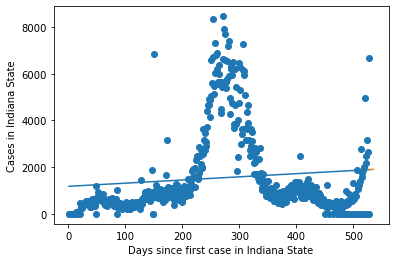

In [14]:
plt.scatter(IN_Day_cases_df.IN_Days_Count, IN_Day_cases_df.IN_New_cases_per_day)
plt.plot(IN_Day_cases_df.IN_Days_Count, IN_Prediction)
plt.plot(IN_New_week.IN_Days_Count, IN_New_week_prediction)
plt.xlabel('Days since first case in Indiana State')
plt.ylabel('Cases in Indiana State')
plt.show("png")

Rsquared values of the Indiana State Cases's Linear Model

In [15]:
IN_Liner_model.rsquared

0.013023341774580977

Root Means Square Error of the Indiana State's Cases Linear Model

In [16]:
sm.rmse(IN_Day_cases_df.IN_New_cases_per_day, IN_Prediction)

1798.553419382575

Pvalues of Indiana Stat's Cases Linear Model

In [17]:
IN_Liner_model.pvalues

Intercept        2.456091e-13
IN_Days_Count    8.674080e-03
dtype: float64

Confidence Interval values of Indiana State's Cases Linear Model

In [18]:
IN_Liner_model.conf_int()

,0,1
Intercept,871.873883,1488.974804
IN_Days_Count,0.344733,2.366199


Plot of predicted cases of Indiana State values using polyinomial from degree 1 to 4.

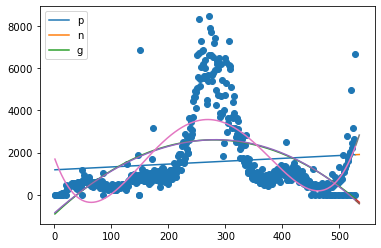

In [19]:
plt.scatter(IN_Day_cases_df.IN_Days_Count, IN_Day_cases_df.IN_New_cases_per_day)
poly1 = smf.ols(formula = 'IN_New_cases_per_day ~ 1+IN_Days_Count', data = IN_Day_cases_df).fit()

plt.plot(IN_Day_cases_df.IN_Days_Count, poly1.predict(IN_Day_cases_df.IN_Days_Count), label = 'poly_1')
plt.plot(IN_New_week.IN_Days_Count, poly1.predict(IN_New_week.IN_Days_Count))

poly2 = smf.ols(formula='IN_New_cases_per_day ~ 1+IN_Days_Count+I(IN_Days_Count**2.0)', data = IN_Day_cases_df).fit()

plt.plot(IN_Day_cases_df.IN_Days_Count, poly2.predict(IN_Day_cases_df.IN_Days_Count), label = 'poly_2')
plt.plot(IN_New_week.IN_Days_Count, poly2.predict(IN_New_week.IN_Days_Count))

poly3 = smf.ols(formula='IN_New_cases_per_day ~ 1+IN_Days_Count+I(IN_Days_Count**2.0)+I(IN_Days_Count**3.0)', data = IN_Day_cases_df).fit()

plt.plot(IN_Day_cases_df.IN_Days_Count, poly3.predict(IN_Day_cases_df.IN_Days_Count),label = 'poly_3')
plt.plot(IN_New_week.IN_Days_Count, poly3.predict(IN_New_week.IN_Days_Count))

poly4 = smf.ols(formula = 'IN_New_cases_per_day ~ 1+IN_Days_Count+I(IN_Days_Count**2.0)+I(IN_Days_Count**3.0)+I(IN_Days_Count**4.0)', data = IN_Day_cases_df).fit()

plt.plot(IN_Day_cases_df.IN_Days_Count, poly4.predict(IN_Day_cases_df.IN_Days_Count),label = 'poly_4')
plt.plot(IN_New_week.IN_Days_Count, poly4.predict(IN_New_week.IN_Days_Count))

plt.legend("png")

In [20]:
print('R-squared value of poly1 is: ', poly1.rsquared)
print('R-squared value of poly2 is: ', poly2.rsquared)
print('R-squared value of poly3 is: ', poly3.rsquared)
print('R-squared value of poly4 is: ', poly4.rsquared)

R-squared value of poly1 is:  0.013023341774580977
R-squared value of poly2 is:  0.28320444645640896
R-squared value of poly3 is:  0.28338096253266887
R-squared value of poly4 is:  0.5097218524819178


Here the Rsquared value of poly 4 is significantly higer than poly3 and all other values. So, we can consider polynomial degree 4.

In [21]:
print('P-values of poly1 is: ', poly1.pvalues)
print('P-values of poly2 is: ', poly2.pvalues)
print('P-values of poly3 is: ', poly3.pvalues)
print('P-values of poly4 is: ', poly4.pvalues)

P-values of poly1 is:  Intercept        2.456091e-13
IN_Days_Count    8.674080e-03
dtype: float64
P-values of poly2 is:  Intercept                  4.301037e-06
IN_Days_Count              7.889937e-40
I(IN_Days_Count ** 2.0)    2.272639e-38
dtype: float64
P-values of poly3 is:  Intercept                  1.312076e-03
IN_Days_Count              9.671375e-08
I(IN_Days_Count ** 2.0)    4.777743e-02
I(IN_Days_Count ** 3.0)    7.195424e-01
dtype: float64
P-values of poly4 is:  Intercept                  6.907039e-10
IN_Days_Count              1.848118e-22
I(IN_Days_Count ** 2.0)    5.435843e-39
I(IN_Days_Count ** 3.0)    9.894815e-45
I(IN_Days_Count ** 4.0)    4.828279e-45
dtype: float64


In [22]:
print('RMSE of ploy1 is:', sm.rmse(IN_Day_cases_df.IN_New_cases_per_day, poly1.predict(IN_Day_cases_df.IN_Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(IN_Day_cases_df.IN_New_cases_per_day, poly2.predict(IN_Day_cases_df.IN_Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(IN_Day_cases_df.IN_New_cases_per_day, poly3.predict(IN_Day_cases_df.IN_Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(IN_Day_cases_df.IN_New_cases_per_day, poly4.predict(IN_Day_cases_df.IN_Days_Count)))

RMSE of ploy1 is: 1798.553419382575
RMSE of ploy2 is: 1532.7366842730946
RMSE of ploy3 is: 1532.5479489199333
RMSE of ploy4 is: 1267.6260888954878


Confidence Interval of polynomial degrees from 1 to 4

In [23]:
poly1.conf_int()

,0,1
Intercept,871.873883,1488.974804
IN_Days_Count,0.344733,2.366199


In [24]:
poly2.conf_int()

,0,1
Intercept,-1331.479945,-540.005786
IN_Days_Count,21.857226,28.766926
I(IN_Days_Count ** 2.0),-0.051611,-0.038962


In [25]:
poly3.conf_int()

,0,1
Intercept,-1401.227951,-341.528823
IN_Days_Count,15.192922,32.524841
I(IN_Days_Count ** 2.0),-0.076473,-0.000378
I(IN_Days_Count ** 3.0),-0.000056,0.000039


In [26]:
poly4.conf_int()

,0,1
Intercept,1211.203138,2312.611790
IN_Days_Count,-89.253805,-60.461976
I(IN_Days_Count ** 2.0),0.688950,0.909985
I(IN_Days_Count ** 3.0),-0.002785,-0.002157
I(IN_Days_Count ** 4.0),0.000002,0.000003


Finding upper and lower bonds of the polynomial degree 4.

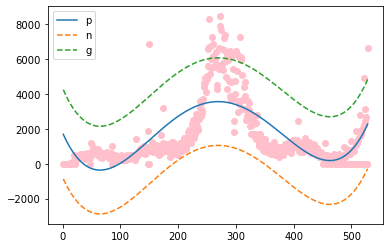

In [27]:
_,upper,lower = wls_prediction_std(poly4)
plt.scatter(IN_Day_cases_df.IN_Days_Count, IN_Day_cases_df.IN_New_cases_per_day,color='pink')
plt.plot(IN_Day_cases_df.IN_Days_Count, poly4.predict(IN_Day_cases_df.IN_Days_Count))
plt.plot(IN_Day_cases_df.IN_Days_Count, upper,'--', label='upper')
plt.plot(IN_Day_cases_df.IN_Days_Count, lower,'--', label='lower')
plt.legend("png")

# Prediction for Deaths in Indiana State

Fitting the linear model to the number of new deaths per day and day count in Indiana State. Deaths are predicted for the available data using the linear model.

In [28]:
IN_Day_deaths_df = Indiana_State[['IN_New_deaths_per_day','IN_Days_Count']]
IN_Deaths_LinearModel = smf.ols(formula='IN_New_deaths_per_day~IN_Days_Count', data = IN_Day_deaths_df).fit()
IN_Deaths_Prediction = IN_Deaths_LinearModel.predict(IN_Day_deaths_df.IN_Days_Count)
IN_Deaths_Prediction

45     28.067237
46     28.062389
47     28.057541
48     28.052692
49     28.047844
         ...    
568    25.531701
569    25.526853
570    25.522005
571    25.517157
572    25.512309
Length: 528, dtype: float64

Linear Model Parameters for Deaths in Indiana State.

In [29]:
IN_Deaths_LinearModel.params

Intercept        28.072085
IN_Days_Count    -0.004848
dtype: float64

Predicting the new deaths in Indiana State for the next week from the given data.

In [30]:
IN_New_week_deaths_prediction = IN_Deaths_LinearModel.predict(IN_New_week.IN_Days_Count)
IN_New_week_deaths_prediction

0    25.507461
1    25.502613
2    25.497765
3    25.492917
4    25.488069
5    25.483220
6    25.478372
dtype: float64

Plot of deaths since the first case in Indiana State day wise and linear model for this data

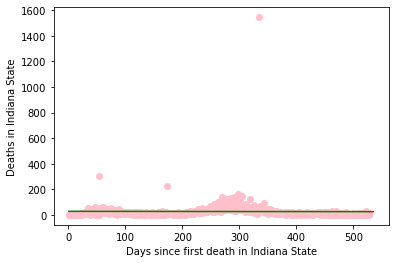

In [31]:
plt.scatter(IN_Day_deaths_df.IN_Days_Count, IN_Day_deaths_df.IN_New_deaths_per_day,color='pink')
plt.plot(IN_Day_deaths_df.IN_Days_Count, IN_Deaths_Prediction,color='green')
plt.plot(IN_New_week.IN_Days_Count, IN_New_week_deaths_prediction,color='red')
plt.xlabel('Days since first death in Indiana State')
plt.ylabel('Deaths in Indiana State')
plt.show("png")

Rsquared values of the Indiana State Deaths's Linear Model

In [32]:
IN_Deaths_LinearModel.rsquared

0.00010343746924501573

Root Means Square Error of the Indiana State's Deaths Linear Model

In [33]:
sm.rmse(IN_Day_deaths_df.IN_New_deaths_per_day, IN_Deaths_Prediction)

72.6522611941084

Pvalues of Indiana Stat's Deaths Linear Model

In [34]:
IN_Deaths_LinearModel.pvalues

Intercept        0.000012
IN_Days_Count    0.815644
dtype: float64

Confidence Interval values of Indiana State's Deaths Linear Model

In [35]:
IN_Deaths_LinearModel.conf_int()

,0,1
Intercept,15.608241,40.535928
IN_Days_Count,-0.045676,0.035980


Plot of predicted deaths of Indiana State values using polyinomial from degree 1 to 4.

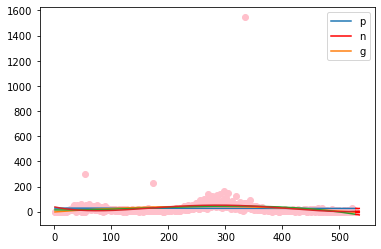

In [36]:
plt.scatter(IN_Day_deaths_df.IN_Days_Count, IN_Day_deaths_df.IN_New_deaths_per_day,color = 'pink')
poly1_d = smf.ols(formula = 'IN_New_deaths_per_day ~ 1+IN_Days_Count', data = IN_Day_deaths_df).fit()

plt.plot(IN_Day_deaths_df.IN_Days_Count, poly1_d.predict(IN_Day_deaths_df.IN_Days_Count), label='poly_1_d')
plt.plot(IN_New_week.IN_Days_Count, poly1_d.predict(IN_New_week.IN_Days_Count), color='red')

poly2_d=smf.ols(formula='IN_New_deaths_per_day ~ 1+IN_Days_Count+I(IN_Days_Count**2.0)', data = IN_Day_deaths_df).fit()

plt.plot(IN_Day_deaths_df.IN_Days_Count,poly2_d.predict(IN_Day_deaths_df.IN_Days_Count), label='poly_2_d')
plt.plot(IN_New_week.IN_Days_Count,poly2_d.predict(IN_New_week.IN_Days_Count), color='red')

poly3_d=smf.ols(formula='IN_New_deaths_per_day ~ 1+IN_Days_Count+I(IN_Days_Count**2.0)+I(IN_Days_Count**3.0)', data=IN_Day_deaths_df).fit()

plt.plot(IN_Day_deaths_df.IN_Days_Count,poly3_d.predict(IN_Day_deaths_df.IN_Days_Count), label='poly_3_d')
plt.plot(IN_New_week.IN_Days_Count,poly3_d.predict(IN_New_week.IN_Days_Count), color='red')

poly4_d=smf.ols(formula='IN_New_deaths_per_day ~ 1+IN_Days_Count+I(IN_Days_Count**2.0)+I(IN_Days_Count**3.0)+I(IN_Days_Count**4.0)',data=IN_Day_deaths_df).fit()

plt.plot(IN_Day_deaths_df.IN_Days_Count, poly4_d.predict(IN_Day_deaths_df.IN_Days_Count), label='poly_4_d')
plt.plot(IN_New_week.IN_Days_Count, poly4_d.predict(IN_New_week.IN_Days_Count), color='red')

plt.legend("png")

Rsqured values of deaths in Indiana state for each polynomial degree and it clear that ploy2 is significantly higher than poly-1. And there is no significant difference from poly-2 to poly3 and 4. So, we are considering poly2.

In [37]:
print('R-squared value of poly1_d is: ', poly1_d.rsquared)
print('R-squared value of poly2_d is: ', poly2_d.rsquared)
print('R-squared value of poly3_d is: ', poly3_d.rsquared)
print('R-squared value of poly4_d is: ', poly4_d.rsquared)

R-squared value of poly1_d is:  0.00010343746924501573
R-squared value of poly2_d is:  0.035067003650371076
R-squared value of poly3_d is:  0.04220733687413314
R-squared value of poly4_d is:  0.053896439944709496


In [38]:
print('P-values of poly1_d is: ', poly1_d.pvalues)
print('P-values of poly2_d is: ', poly2_d.pvalues)
print('P-values of poly3_d is: ', poly3_d.pvalues)
print('P-values of poly4_d is: ', poly4_d.pvalues)

P-values of poly1_d is:  Intercept        0.000012
IN_Days_Count    0.815644
dtype: float64
P-values of poly2_d is:  Intercept                  0.791635
IN_Days_Count              0.000037
I(IN_Days_Count ** 2.0)    0.000016
dtype: float64
P-values of poly3_d is:  Intercept                  0.265473
IN_Days_Count              0.883859
I(IN_Days_Count ** 2.0)    0.222505
I(IN_Days_Count ** 3.0)    0.048626
dtype: float64
P-values of poly4_d is:  Intercept                  0.015463
IN_Days_Count              0.023190
I(IN_Days_Count ** 2.0)    0.005522
I(IN_Days_Count ** 3.0)    0.005805
I(IN_Days_Count ** 4.0)    0.011310
dtype: float64


In [39]:
print('RMSE of ploy1 is:', sm.rmse(IN_Day_deaths_df.IN_New_deaths_per_day, poly1.predict(IN_Day_deaths_df.IN_Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(IN_Day_deaths_df.IN_New_deaths_per_day, poly2.predict(IN_Day_deaths_df.IN_Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(IN_Day_deaths_df.IN_New_deaths_per_day, poly3.predict(IN_Day_deaths_df.IN_Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(IN_Day_deaths_df.IN_New_deaths_per_day, poly4.predict(IN_Day_deaths_df.IN_Days_Count)))

RMSE of ploy1 is: 1528.0319390717375
RMSE of ploy2 is: 1787.4075282858523
RMSE of ploy3 is: 1787.4867439705563
RMSE of ploy4 is: 1980.7582226374248


Confidence Interveles of polynomial degrees from 1 to 4.

In [40]:
poly1_d.conf_int()

,0,1
Intercept,15.608241,40.535928
IN_Days_Count,-0.045676,0.035980


In [41]:
poly2_d.conf_int()

,0,1
Intercept,-20.906582,15.947820
IN_Days_Count,0.180145,0.501890
I(IN_Days_Count ** 2.0),-0.000948,-0.000359


In [42]:
poly3_d.conf_int()

,0,1
Intercept,-10.633854,3.853339e+01
IN_Days_Count,-0.431990,3.721649e-01
I(IN_Days_Count ** 2.0),-0.000668,2.862831e-03
I(IN_Days_Count ** 3.0),-0.000004,-1.335943e-08


In [43]:
poly4_d.conf_int()

,0,1
Intercept,7.264103e+00,6.866833e+01
IN_Days_Count,-1.732824e+00,-1.276615e-01
I(IN_Days_Count ** 2.0),2.577951e-03,1.490080e-02
I(IN_Days_Count ** 3.0),-4.215642e-05,-7.172073e-06
I(IN_Days_Count ** 4.0),4.821989e-09,3.763011e-08


Upper and lower bonds of Indiana State's Deaths polynomial degree 2.

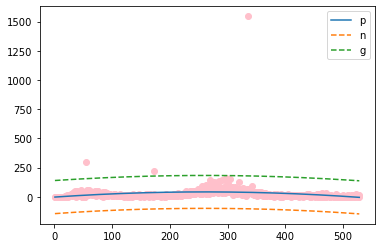

In [44]:
_,upper,lower=wls_prediction_std(poly2_d)
plt.scatter(IN_Day_deaths_df.IN_Days_Count, IN_Day_deaths_df.IN_New_deaths_per_day,color='pink')
plt.plot(IN_Day_deaths_df.IN_Days_Count, poly2_d.predict(IN_Day_deaths_df.IN_Days_Count))
plt.plot(IN_Day_deaths_df.IN_Days_Count, upper,'--',label='upper')
plt.plot(IN_Day_deaths_df.IN_Days_Count, lower,'--',label='lower')
plt.legend("png")

# Top 5 counties are:

We calculated the top 5 infected counties in Stage 2. So, using the same counties here to fit a linear model and predict future cases and deaths.

18017 - Cass County, 
18037 - Dubois County, 
18045 - Fountain County, 
18023 - Clinton County and
18039 - Elkhart County

In [45]:
CassCounty = Indiana_df[Indiana_df['countyFIPS'] == 18017]
DuboisCounty = Indiana_df[Indiana_df['countyFIPS'] == 18037]
FountainCounty = Indiana_df[Indiana_df['countyFIPS'] == 18045]
ClintonCounty = Indiana_df[Indiana_df['countyFIPS'] == 18023]
ElkhartCounty = Indiana_df[Indiana_df['countyFIPS'] == 18039]

In [46]:
CassCounty = CassCounty[CassCounty['Cases']>0]
CassCounty['New_cases_per_day'] = round((CassCounty['Cases'].diff()/CassCounty['population'])*100000,0)
CassCounty['New_deaths_per_day'] = round((CassCounty['Deaths'].diff()/CassCounty['population'])*100000,0)
CassCounty = CassCounty.dropna()
CassCounty.New_cases_per_day = CassCounty.New_cases_per_day.astype(int)
CassCounty.New_deaths_per_day = CassCounty.New_deaths_per_day.astype(int)

In [47]:
CassCounty['Days_Count'] = 0
CassCounty['New_cases_per_day'][CassCounty['New_cases_per_day']<0]=0
CassCounty['New_deaths_per_day'][CassCounty['New_deaths_per_day']<0]=0
DaysList=[]
for i in range(0,len(CassCounty)):
    count=i+1
    DaysList.append(count)
CassCounty['Days_Count'] = DaysList
CassCounty

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases,New_cases_per_day,New_deaths_per_day,Days_Count
220645,18017,IN,Cass County,18,37689,2020-04-01,0,1,0,0,1
223787,18017,IN,Cass County,18,37689,2020-04-02,0,2,3,0,2
226929,18017,IN,Cass County,18,37689,2020-04-03,0,2,0,0,3
230071,18017,IN,Cass County,18,37689,2020-04-04,0,4,5,0,4
233213,18017,IN,Cass County,18,37689,2020-04-05,0,4,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
1785361,18017,IN,Cass County,18,37689,2021-08-12,114,6241,40,0,499
1788503,18017,IN,Cass County,18,37689,2021-08-13,114,6264,61,0,500
1791645,18017,IN,Cass County,18,37689,2021-08-14,114,6264,0,0,501
1794787,18017,IN,Cass County,18,37689,2021-08-15,114,6264,0,0,502


In [48]:
Day_cases_df = CassCounty[['New_cases_per_day','Days_Count']]
Liner_model  = smf.ols(formula='New_cases_per_day~Days_Count', data=Day_cases_df).fit()
Prediction   = Liner_model.predict(Day_cases_df.Days_Count)
Prediction

220645     47.602078
223787     47.545225
226929     47.488372
230071     47.431519
233213     47.374667
             ...    
1785361    19.289349
1788503    19.232497
1791645    19.175644
1794787    19.118791
1797929    19.061938
Length: 503, dtype: float64

In [49]:
New_week=pd.DataFrame({'Days_Count':[504,505,506,507,508,509,510]})
New_week

,Days_Count
0,504
1,505
2,506
3,507
4,508
5,509
6,510


In [50]:
New_week_prediction = Liner_model.predict(New_week.Days_Count)
New_week_prediction

0    19.005085
1    18.948232
2    18.891379
3    18.834526
4    18.777674
5    18.720821
6    18.663968
dtype: float64

In [51]:
Liner_model.params

Intercept     47.658931
Days_Count    -0.056853
dtype: float64

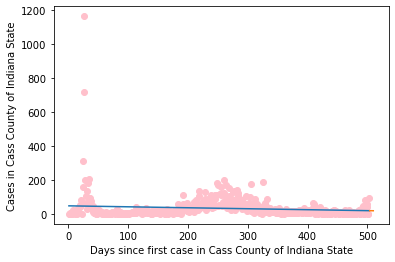

In [52]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day, color='pink')
plt.plot(Day_cases_df.Days_Count, Prediction)
plt.plot(New_week.Days_Count, New_week_prediction)
plt.xlabel('Days since first case in Cass County of Indiana State')
plt.ylabel('Cases in Cass County of Indiana State')
plt.show("png")

In [53]:
Liner_model.rsquared

0.01341003729831447

In [54]:
sm.rmse(Day_cases_df.New_cases_per_day, Prediction)

70.80798585272849

In [55]:
Liner_model.pvalues

Intercept     2.524412e-13
Days_Count    9.337312e-03
dtype: float64

In [56]:
Liner_model.conf_int()

,0,1
Intercept,35.209779,60.108083
Days_Count,-0.099657,-0.014049


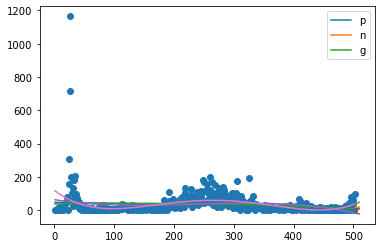

In [57]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
poly1 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly1.predict(Day_cases_df.Days_Count), label = 'poly_1')
plt.plot(New_week.Days_Count, poly1.predict(New_week.Days_Count))

poly2 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly2.predict(Day_cases_df.Days_Count), label = 'poly_2')
plt.plot(New_week.Days_Count, poly2.predict(New_week.Days_Count))

poly3 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly3.predict(Day_cases_df.Days_Count),label = 'poly_3')
plt.plot(New_week.Days_Count, poly3.predict(New_week.Days_Count))

poly4 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count),label = 'poly_4')
plt.plot(New_week.Days_Count, poly4.predict(New_week.Days_Count))

plt.legend("png")

In [58]:
print('R-squared value of poly1 is: ', poly1.rsquared)
print('R-squared value of poly2 is: ', poly2.rsquared)
print('R-squared value of poly3 is: ', poly3.rsquared)
print('R-squared value of poly4 is: ', poly4.rsquared)

R-squared value of poly1 is:  0.01341003729831447
R-squared value of poly2 is:  0.017266908722426977
R-squared value of poly3 is:  0.03582742558575036
R-squared value of poly4 is:  0.10249051721563396


In [59]:
print('P-values of poly1 is: ', poly1.pvalues)
print('P-values of poly2 is: ', poly2.pvalues)
print('P-values of poly3 is: ', poly3.pvalues)
print('P-values of poly4 is: ', poly4.pvalues)

P-values of poly1 is:  Intercept     2.524412e-13
Days_Count    9.337312e-03
dtype: float64
P-values of poly2 is:  Intercept               0.000086
Days_Count              0.481312
I(Days_Count ** 2.0)    0.161886
dtype: float64
P-values of poly3 is:  Intercept               6.376768e-07
Days_Count              1.080841e-02
I(Days_Count ** 2.0)    4.976067e-03
I(Days_Count ** 3.0)    2.049072e-03
dtype: float64
P-values of poly4 is:  Intercept               2.797678e-14
Days_Count              1.100983e-10
I(Days_Count ** 2.0)    7.161656e-11
I(Days_Count ** 3.0)    2.909477e-10
I(Days_Count ** 4.0)    2.368252e-09
dtype: float64


In [60]:
print('RMSE of ploy1 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly1.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly2.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly3.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly4.predict(Day_cases_df.Days_Count)))

RMSE of ploy1 is: 70.80798585272849
RMSE of ploy2 is: 70.66944566124013
RMSE of ploy3 is: 69.99891067570582
RMSE of ploy4 is: 67.5357018500736


In [61]:
poly1.conf_int()

,0,1
Intercept,35.209779,60.108083
Days_Count,-0.099657,-0.014049


In [62]:
poly2.conf_int()

,0,1
Intercept,18.997723,56.402552
Days_Count,-0.109904,0.232843
I(Days_Count ** 2.0),-0.000564,0.000095


In [63]:
poly3.conf_int()

,0,1
Intercept,38.892731,88.515339
Days_Count,-0.980525,-0.128703
I(Days_Count ** 2.0),0.000856,0.004781
I(Days_Count ** 3.0),-0.000007,-0.000001


In [64]:
poly4.conf_int()

,0,1
Intercept,8.994235e+01,1.501185e+02
Days_Count,-3.595456e+00,-1.944532e+00
I(Days_Count ** 2.0),1.590157e-02,2.920352e-02
I(Days_Count ** 3.0),-8.472461e-05,-4.508829e-05
I(Days_Count ** 4.0),4.087781e-08,7.989237e-08


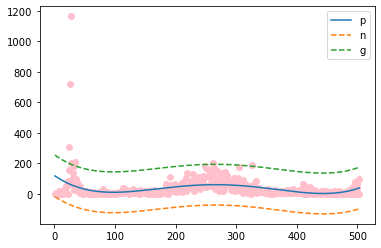

In [65]:
_,upper,lower = wls_prediction_std(poly4)
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day,color='pink')
plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count))
plt.plot(Day_cases_df.Days_Count, upper,'--', label='upper')
plt.plot(Day_cases_df.Days_Count, lower,'--', label='lower')
plt.legend("png")

# Deaths in Cass County

In [66]:
Day_deaths_df = CassCounty[['New_deaths_per_day','Days_Count']]
Deaths_LinearModel = smf.ols(formula='New_deaths_per_day~Days_Count', data = Day_deaths_df).fit()
Deaths_Prediction = Deaths_LinearModel.predict(Day_deaths_df.Days_Count)
Deaths_Prediction

220645     0.480687
223787     0.481291
226929     0.481895
230071     0.482498
233213     0.483102
             ...   
1785361    0.781312
1788503    0.781915
1791645    0.782519
1794787    0.783123
1797929    0.783726
Length: 503, dtype: float64

In [67]:
Deaths_LinearModel.params

Intercept     0.480084
Days_Count    0.000604
dtype: float64

In [68]:
New_week_deaths_prediction = Deaths_LinearModel.predict(New_week.Days_Count)
New_week_deaths_prediction

0    0.784330
1    0.784934
2    0.785537
3    0.786141
4    0.786745
5    0.787348
6    0.787952
dtype: float64

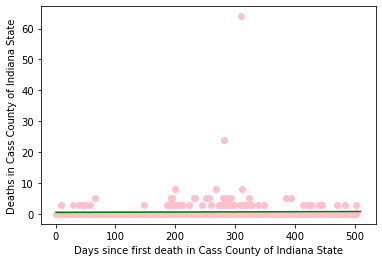

In [69]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, Deaths_Prediction,color='green')
plt.plot(New_week.Days_Count, New_week_deaths_prediction,color='red')
plt.xlabel('Days since first death in Cass County of Indiana State')
plt.ylabel('Deaths in Cass County of Indiana State')
plt.show("png")

In [70]:
Deaths_LinearModel.rsquared

0.000714226835746512

In [71]:
sm.rmse(Day_deaths_df.New_deaths_per_day, Deaths_Prediction)

3.2786718444263703

In [72]:
Deaths_LinearModel.pvalues

Intercept     0.102407
Days_Count    0.549843
dtype: float64

In [73]:
Deaths_LinearModel.conf_int()

,0,1
Intercept,-0.096358,1.056525
Days_Count,-0.001378,0.002586


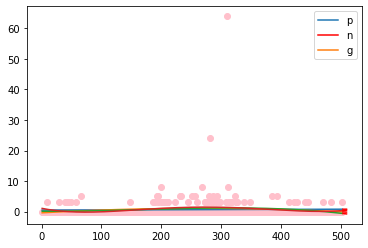

In [74]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color = 'pink')
poly1_d = smf.ols(formula = 'New_deaths_per_day ~ 1+Days_Count', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly1_d.predict(Day_deaths_df.Days_Count), label='poly_1_d')
plt.plot(New_week.Days_Count, poly1_d.predict(New_week.Days_Count), color='red')

poly2_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly2_d.predict(Day_deaths_df.Days_Count), label='poly_2_d')
plt.plot(New_week.Days_Count,poly2_d.predict(New_week.Days_Count), color='red')

poly3_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly3_d.predict(Day_deaths_df.Days_Count), label='poly_3_d')
plt.plot(New_week.Days_Count,poly3_d.predict(New_week.Days_Count), color='red')

poly4_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)',data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly4_d.predict(Day_deaths_df.Days_Count), label='poly_4_d')
plt.plot(New_week.Days_Count, poly4_d.predict(New_week.Days_Count), color='red')

plt.legend("png")

In [75]:
print('R-squared value of poly1_d is: ', poly1_d.rsquared)
print('R-squared value of poly2_d is: ', poly2_d.rsquared)
print('R-squared value of poly3_d is: ', poly3_d.rsquared)
print('R-squared value of poly4_d is: ', poly4_d.rsquared)

R-squared value of poly1_d is:  0.000714226835746512
R-squared value of poly2_d is:  0.015249373743422612
R-squared value of poly3_d is:  0.01876149443005881
R-squared value of poly4_d is:  0.028135657668636238


In [76]:
print('P-values of poly1_d is: ', poly1_d.pvalues)
print('P-values of poly2_d is: ', poly2_d.pvalues)
print('P-values of poly3_d is: ', poly3_d.pvalues)
print('P-values of poly4_d is: ', poly4_d.pvalues)

P-values of poly1_d is:  Intercept     0.102407
Days_Count    0.549843
dtype: float64
P-values of poly2_d is:  Intercept               0.350844
Days_Count              0.005624
I(Days_Count ** 2.0)    0.006823
dtype: float64
P-values of poly3_d is:  Intercept               0.849827
Days_Count              0.908390
I(Days_Count ** 2.0)    0.387143
I(Days_Count ** 3.0)    0.182016
dtype: float64
P-values of poly4_d is:  Intercept               0.140337
Days_Count              0.050815
I(Days_Count ** 2.0)    0.019244
I(Days_Count ** 3.0)    0.019578
I(Days_Count ** 4.0)    0.028865
dtype: float64


In [77]:
print('RMSE of ploy1 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly1.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly2.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly3.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly4.predict(Day_deaths_df.Days_Count)))

RMSE of ploy1 is: 33.90619864603722
RMSE of ploy2 is: 34.14277899819973
RMSE of ploy3 is: 35.44399656437719
RMSE of ploy4 is: 39.7915000132957


In [78]:
poly1_d.conf_int()

,0,1
Intercept,-0.096358,1.056525
Days_Count,-0.001378,0.002586


In [79]:
poly2_d.conf_int()

,0,1
Intercept,-1.270755,0.451955
Days_Count,0.003279,0.019065
I(Days_Count ** 2.0),-0.000036,-0.000006


In [80]:
poly3_d.conf_int()

,0,1
Intercept,-1.040556e+00,1.262628e+00
Days_Count,-2.092658e-02,1.860985e-02
I(Days_Count ** 2.0),-5.096279e-05,1.312273e-04
I(Days_Count ** 3.0),-1.996385e-07,3.799625e-08


In [81]:
poly4_d.conf_int()

,0,1
Intercept,-3.576819e-01,2.523344e+00
Days_Count,-7.890039e-02,1.400999e-04
I(Days_Count ** 2.0),6.218243e-05,6.990335e-04
I(Days_Count ** 3.0),-2.079799e-06,-1.821508e-07
I(Days_Count ** 4.0),1.078789e-10,1.975760e-09


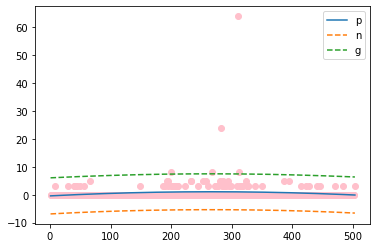

In [82]:
_,upper,lower=wls_prediction_std(poly2_d)
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, poly2_d.predict(Day_deaths_df.Days_Count))
plt.plot(Day_deaths_df.Days_Count, upper,'--',label='upper')
plt.plot(Day_deaths_df.Days_Count, lower,'--',label='lower')
plt.legend("png")

# DuboisCounty

In [83]:
DuboisCounty = DuboisCounty[DuboisCounty['Cases']>0]
DuboisCounty['New_cases_per_day'] = round((DuboisCounty['Cases'].diff()/DuboisCounty['population'])*100000,0)
DuboisCounty['New_deaths_per_day'] = round((DuboisCounty['Deaths'].diff()/DuboisCounty['population'])*100000,0)
DuboisCounty = DuboisCounty.dropna()
DuboisCounty.New_cases_per_day = DuboisCounty.New_cases_per_day.astype(int)
DuboisCounty.New_deaths_per_day = DuboisCounty.New_deaths_per_day.astype(int)

In [84]:
DuboisCounty['Days_Count'] = 0
DuboisCounty['New_cases_per_day'][DuboisCounty['New_cases_per_day']<0]=0
DuboisCounty['New_deaths_per_day'][DuboisCounty['New_deaths_per_day']<0]=0
DaysList=[]
for i in range(0,len(DuboisCounty)):
    count=i+1
    DaysList.append(count)
DuboisCounty['Days_Count'] = DaysList
DuboisCounty

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases,New_cases_per_day,New_deaths_per_day,Days_Count
192377,18037,IN,Dubois County,18,42736,2020-03-23,0,1,0,0,1
195519,18037,IN,Dubois County,18,42736,2020-03-24,0,1,0,0,2
198661,18037,IN,Dubois County,18,42736,2020-03-25,0,1,0,0,3
201803,18037,IN,Dubois County,18,42736,2020-03-26,0,1,0,0,4
204945,18037,IN,Dubois County,18,42736,2020-03-27,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
1785371,18037,IN,Dubois County,18,42736,2021-08-12,119,6485,54,0,508
1788513,18037,IN,Dubois County,18,42736,2021-08-13,119,6501,37,0,509
1791655,18037,IN,Dubois County,18,42736,2021-08-14,119,6501,0,0,510
1794797,18037,IN,Dubois County,18,42736,2021-08-15,119,6501,0,0,511


In [85]:
Day_cases_df = DuboisCounty[['New_cases_per_day','Days_Count']]
Liner_model  = smf.ols(formula='New_cases_per_day~Days_Count', data=Day_cases_df).fit()
Prediction   = Liner_model.predict(Day_cases_df.Days_Count)
Prediction

192377     28.830227
195519     28.834041
198661     28.837854
201803     28.841668
204945     28.845482
             ...    
1785371    30.763893
1788513    30.767707
1791655    30.771521
1794797    30.775334
1797939    30.779148
Length: 512, dtype: float64

In [86]:
New_week=pd.DataFrame({'Days_Count':[513,514,515,516,517,518,519]})
New_week

,Days_Count
0,513
1,514
2,515
3,516
4,517
5,518
6,519


In [87]:
New_week_prediction = Liner_model.predict(New_week.Days_Count)
New_week_prediction

0    30.782962
1    30.786776
2    30.790590
3    30.794404
4    30.798218
5    30.802032
6    30.805846
dtype: float64

In [88]:
Liner_model.params

Intercept     28.826413
Days_Count     0.003814
dtype: float64

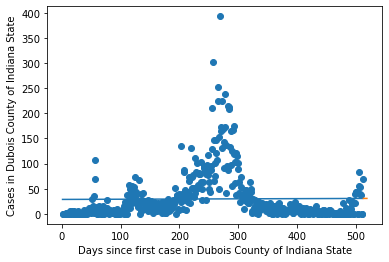

In [89]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
plt.plot(Day_cases_df.Days_Count, Prediction)
plt.plot(New_week.Days_Count, New_week_prediction)
plt.xlabel('Days since first case in Dubois County of Indiana State')
plt.ylabel('Cases in Dubois County of Indiana State')
plt.show("png")

In [90]:
Liner_model.rsquared

0.00013939976287657974

In [91]:
sm.rmse(Day_cases_df.New_cases_per_day, Prediction)

47.74091401258098

In [92]:
Liner_model.pvalues

Intercept     2.790100e-11
Days_Count    7.898442e-01
dtype: float64

In [93]:
Liner_model.conf_int()

,0,1
Intercept,20.507777,37.145048
Days_Count,-0.024286,0.031914


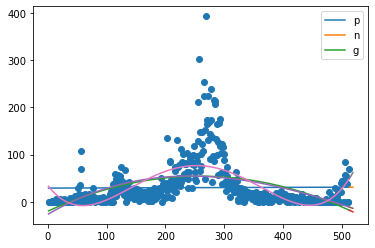

In [94]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
poly1 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly1.predict(Day_cases_df.Days_Count), label = 'poly_1')
plt.plot(New_week.Days_Count, poly1.predict(New_week.Days_Count))

poly2 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly2.predict(Day_cases_df.Days_Count), label = 'poly_2')
plt.plot(New_week.Days_Count, poly2.predict(New_week.Days_Count))

poly3 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly3.predict(Day_cases_df.Days_Count),label = 'poly_3')
plt.plot(New_week.Days_Count, poly3.predict(New_week.Days_Count))

poly4 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count),label = 'poly_4')
plt.plot(New_week.Days_Count, poly4.predict(New_week.Days_Count))

plt.legend("png")

In [95]:
print('R-squared value of poly1 is: ', poly1.rsquared)
print('R-squared value of poly2 is: ', poly2.rsquared)
print('R-squared value of poly3 is: ', poly3.rsquared)
print('R-squared value of poly4 is: ', poly4.rsquared)

R-squared value of poly1 is:  0.00013939976287657974
R-squared value of poly2 is:  0.20754018500494587
R-squared value of poly3 is:  0.21017777521987757
R-squared value of poly4 is:  0.3830438403367038


In [96]:
print('P-values of poly1 is: ', poly1.pvalues)
print('P-values of poly2 is: ', poly2.pvalues)
print('P-values of poly3 is: ', poly3.pvalues)
print('P-values of poly4 is: ', poly4.pvalues)

P-values of poly1 is:  Intercept     2.790100e-11
Days_Count    7.898442e-01
dtype: float64
P-values of poly2 is:  Intercept               4.385990e-04
Days_Count              2.217576e-26
I(Days_Count ** 2.0)    1.555471e-27
dtype: float64
P-values of poly3 is:  Intercept               4.840588e-04
Days_Count              2.191843e-08
I(Days_Count ** 2.0)    1.432573e-03
I(Days_Count ** 3.0)    1.933427e-01
dtype: float64
P-values of poly4 is:  Intercept               6.045851e-05
Days_Count              3.471354e-12
I(Days_Count ** 2.0)    4.622443e-23
I(Days_Count ** 3.0)    6.331934e-28
I(Days_Count ** 4.0)    4.807440e-29
dtype: float64


In [97]:
print('RMSE of ploy1 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly1.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly2.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly3.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly4.predict(Day_cases_df.Days_Count)))

RMSE of ploy1 is: 47.74091401258098
RMSE of ploy2 is: 42.50202536866111
RMSE of ploy3 is: 42.43123543121658
RMSE of ploy4 is: 37.50145811495486


In [98]:
poly1.conf_int()

,0,1
Intercept,20.507777,37.145048
Days_Count,-0.024286,0.031914


In [99]:
poly2.conf_int()

,0,1
Intercept,-31.225748,-8.932022
Days_Count,0.474344,0.675042
I(Days_Count ** 2.0),-0.001302,-0.000923


In [100]:
poly3.conf_int()

,0,1
Intercept,-4.154624e+01,-11.739363
Days_Count,4.761416e-01,0.978838
I(Days_Count ** 2.0),-2.994667e-03,-0.000719
I(Days_Count ** 3.0),-4.914746e-07,0.000002


In [101]:
poly4.conf_int()

,0,1
Intercept,1.752963e+01,5.063814e+01
Days_Count,-2.065632e+00,-1.173208e+00
I(Days_Count ** 2.0),1.515110e-02,2.221564e-02
I(Days_Count ** 3.0),-7.161650e-05,-5.093518e-05
I(Days_Count ** 4.0),5.066540e-08,7.066515e-08


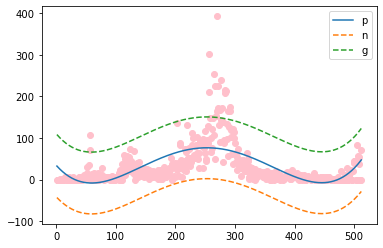

In [102]:
_,upper,lower = wls_prediction_std(poly4)
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day,color='pink')
plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count))
plt.plot(Day_cases_df.Days_Count, upper,'--', label='upper')
plt.plot(Day_cases_df.Days_Count, lower,'--', label='lower')
plt.legend("png")

# DuboisCounty Deaths

In [103]:
Day_deaths_df = DuboisCounty[['New_deaths_per_day','Days_Count']]
Deaths_LinearModel = smf.ols(formula='New_deaths_per_day~Days_Count', data = Day_deaths_df).fit()
Deaths_Prediction = Deaths_LinearModel.predict(Day_deaths_df.Days_Count)
Deaths_Prediction

192377     0.435650
195519     0.435978
198661     0.436306
201803     0.436635
204945     0.436963
             ...   
1785371    0.602100
1788513    0.602428
1791655    0.602756
1794797    0.603085
1797939    0.603413
Length: 512, dtype: float64

In [104]:
Deaths_LinearModel.params

Intercept     0.435321
Days_Count    0.000328
dtype: float64

In [105]:
New_week_deaths_prediction = Deaths_LinearModel.predict(New_week.Days_Count)
New_week_deaths_prediction

0    0.603741
1    0.604069
2    0.604398
3    0.604726
4    0.605054
5    0.605383
6    0.605711
dtype: float64

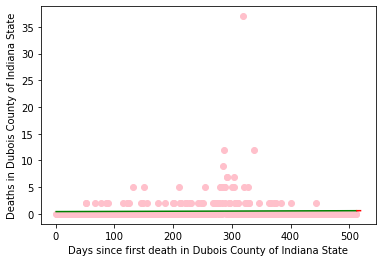

In [106]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, Deaths_Prediction,color='green')
plt.plot(New_week.Days_Count, New_week_deaths_prediction,color='red')
plt.xlabel('Days since first death in Dubois County of Indiana State')
plt.ylabel('Deaths in Dubois County of Indiana State')
plt.show("png")

In [107]:
Deaths_LinearModel.rsquared

0.0005260181887399851

In [108]:
sm.rmse(Day_deaths_df.New_deaths_per_day, Deaths_Prediction)

2.1151421885148576

In [109]:
Deaths_LinearModel.pvalues

Intercept     0.020705
Days_Count    0.604625
dtype: float64

In [110]:
Deaths_LinearModel.conf_int()

,0,1
Intercept,0.066768,0.803875
Days_Count,-0.000917,0.001573


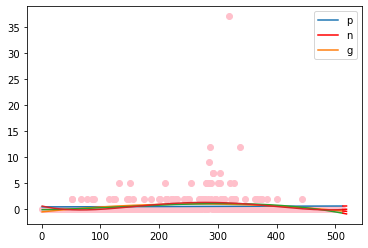

In [111]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color = 'pink')
poly1_d = smf.ols(formula = 'New_deaths_per_day ~ 1+Days_Count', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly1_d.predict(Day_deaths_df.Days_Count), label='poly_1_d')
plt.plot(New_week.Days_Count, poly1_d.predict(New_week.Days_Count), color='red')

poly2_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly2_d.predict(Day_deaths_df.Days_Count), label='poly_2_d')
plt.plot(New_week.Days_Count,poly2_d.predict(New_week.Days_Count), color='red')

poly3_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly3_d.predict(Day_deaths_df.Days_Count), label='poly_3_d')
plt.plot(New_week.Days_Count,poly3_d.predict(New_week.Days_Count), color='red')

poly4_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)',data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly4_d.predict(Day_deaths_df.Days_Count), label='poly_4_d')
plt.plot(New_week.Days_Count, poly4_d.predict(New_week.Days_Count), color='red')

plt.legend("png")

In [112]:
print('R-squared value of poly1_d is: ', poly1_d.rsquared)
print('R-squared value of poly2_d is: ', poly2_d.rsquared)
print('R-squared value of poly3_d is: ', poly3_d.rsquared)
print('R-squared value of poly4_d is: ', poly4_d.rsquared)

R-squared value of poly1_d is:  0.0005260181887399851
R-squared value of poly2_d is:  0.04130899394108445
R-squared value of poly3_d is:  0.047012397339618706
R-squared value of poly4_d is:  0.059213259483769765


In [113]:
print('P-values of poly1_d is: ', poly1_d.pvalues)
print('P-values of poly2_d is: ', poly2_d.pvalues)
print('P-values of poly3_d is: ', poly3_d.pvalues)
print('P-values of poly4_d is: ', poly4_d.pvalues)

P-values of poly1_d is:  Intercept     0.020705
Days_Count    0.604625
dtype: float64
P-values of poly2_d is:  Intercept               0.057876
Days_Count              0.000004
I(Days_Count ** 2.0)    0.000004
dtype: float64
P-values of poly3_d is:  Intercept               0.790891
Days_Count              0.798626
I(Days_Count ** 2.0)    0.345758
I(Days_Count ** 3.0)    0.081828
dtype: float64
P-values of poly4_d is:  Intercept               0.181474
Days_Count              0.036647
I(Days_Count ** 2.0)    0.006587
I(Days_Count ** 3.0)    0.005937
I(Days_Count ** 4.0)    0.010628
dtype: float64


In [114]:
print('RMSE of ploy1 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly1.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly2.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly3.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly4.predict(Day_deaths_df.Days_Count)))

RMSE of ploy1 is: 29.365960140606575
RMSE of ploy2 is: 36.284323947395386
RMSE of ploy3 is: 36.377852482088514
RMSE of ploy4 is: 41.329414990444484


In [115]:
poly1_d.conf_int()

,0,1
Intercept,0.066768,0.803875
Days_Count,-0.000917,0.001573


In [116]:
poly2_d.conf_int()

,0,1
Intercept,-1.068973,0.017618
Days_Count,0.006655,0.016437
I(Days_Count ** 2.0),-0.000031,-0.000013


In [117]:
poly3_d.conf_int()

,0,1
Intercept,-8.233926e-01,6.274766e-01
Days_Count,-1.064496e-02,1.382413e-02
I(Days_Count ** 2.0),-2.878322e-05,8.199707e-05
I(Days_Count ** 3.0),-1.339734e-07,7.984729e-09


In [118]:
poly4_d.conf_int()

,0,1
Intercept,-2.889052e-01,1.522814e+00
Days_Count,-5.045671e-02,-1.622678e-03
I(Days_Count ** 2.0),7.512973e-05,4.617056e-04
I(Days_Count ** 3.0),-1.361600e-06,-2.299051e-07
I(Days_Count ** 4.0),1.669897e-10,1.261389e-09


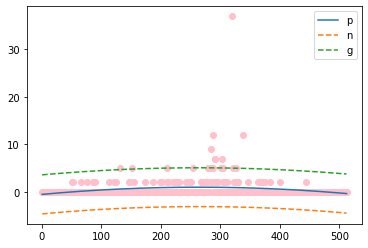

In [119]:
_,upper,lower=wls_prediction_std(poly2_d)
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, poly2_d.predict(Day_deaths_df.Days_Count))
plt.plot(Day_deaths_df.Days_Count, upper,'--',label='upper')
plt.plot(Day_deaths_df.Days_Count, lower,'--',label='lower')
plt.legend("png")

# Fountain County

In [120]:
FountainCounty = FountainCounty[FountainCounty['Cases']>0]
FountainCounty['New_cases_per_day'] = round((FountainCounty['Cases'].diff()/FountainCounty['population'])*100000,0)
FountainCounty['New_deaths_per_day'] = round((FountainCounty['Deaths'].diff()/FountainCounty['population'])*100000,0)
FountainCounty = FountainCounty.dropna()
FountainCounty.New_cases_per_day = FountainCounty.New_cases_per_day.astype(int)
FountainCounty.New_deaths_per_day = FountainCounty.New_deaths_per_day.astype(int)

In [121]:
FountainCounty['Days_Count'] = 0
FountainCounty['New_cases_per_day'][FountainCounty['New_cases_per_day']<0]=0
FountainCounty['New_deaths_per_day'][FountainCounty['New_deaths_per_day']<0]=0
DaysList=[]
for i in range(0,len(FountainCounty)):
    count=i+1
    DaysList.append(count)
FountainCounty['Days_Count'] = DaysList
FountainCounty

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases,New_cases_per_day,New_deaths_per_day,Days_Count
211233,18045,IN,Fountain County,18,16346,2020-03-29,0,1,0,0,1
214375,18045,IN,Fountain County,18,16346,2020-03-30,0,1,0,0,2
217517,18045,IN,Fountain County,18,16346,2020-03-31,0,1,0,0,3
220659,18045,IN,Fountain County,18,16346,2020-04-01,0,1,0,0,4
223801,18045,IN,Fountain County,18,16346,2020-04-02,1,2,6,6,5
...,...,...,...,...,...,...,...,...,...,...,...
1785375,18045,IN,Fountain County,18,16346,2021-08-12,51,2464,80,0,502
1788517,18045,IN,Fountain County,18,16346,2021-08-13,51,2466,12,0,503
1791659,18045,IN,Fountain County,18,16346,2021-08-14,51,2466,0,0,504
1794801,18045,IN,Fountain County,18,16346,2021-08-15,51,2466,0,0,505


In [122]:
Day_cases_df = FountainCounty[['New_cases_per_day','Days_Count']]
Liner_model  = smf.ols(formula='New_cases_per_day~Days_Count', data=Day_cases_df).fit()
Prediction   = Liner_model.predict(Day_cases_df.Days_Count)
Prediction

211233     18.704189
214375     18.749003
217517     18.793817
220659     18.838631
223801     18.883445
             ...    
1785375    41.156080
1788517    41.200894
1791659    41.245709
1794801    41.290523
1797943    41.335337
Length: 506, dtype: float64

In [123]:
New_week=pd.DataFrame({'Days_Count':[507,508,509,510,511,512,513]})
New_week

,Days_Count
0,507
1,508
2,509
3,510
4,511
5,512
6,513


In [124]:
New_week_prediction = Liner_model.predict(New_week.Days_Count)
New_week_prediction

0    41.380151
1    41.424965
2    41.469779
3    41.514594
4    41.559408
5    41.604222
6    41.649036
dtype: float64

In [125]:
Liner_model.params

Intercept     18.659375
Days_Count     0.044814
dtype: float64

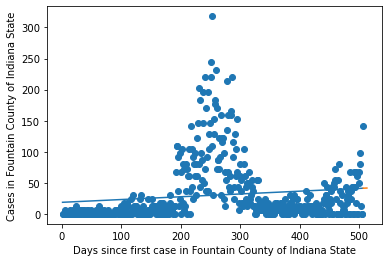

In [126]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
plt.plot(Day_cases_df.Days_Count, Prediction)
plt.plot(New_week.Days_Count, New_week_prediction)
plt.xlabel('Days since first case in Fountain County of Indiana State')
plt.ylabel('Cases in Fountain County of Indiana State')
plt.show("png")

In [127]:
Liner_model.rsquared

0.018922352212750293

In [128]:
sm.rmse(Day_cases_df.New_cases_per_day, Prediction)

47.13444353018874

In [129]:
Liner_model.pvalues

Intercept     0.000011
Days_Count    0.001926
dtype: float64

In [130]:
Liner_model.conf_int()

,0,1
Intercept,10.397294,26.921455
Days_Count,0.016575,0.073054


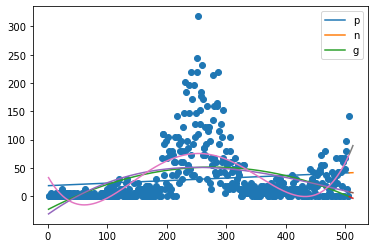

In [131]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
poly1 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly1.predict(Day_cases_df.Days_Count), label = 'poly_1')
plt.plot(New_week.Days_Count, poly1.predict(New_week.Days_Count))

poly2 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly2.predict(Day_cases_df.Days_Count), label = 'poly_2')
plt.plot(New_week.Days_Count, poly2.predict(New_week.Days_Count))

poly3 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly3.predict(Day_cases_df.Days_Count),label = 'poly_3')
plt.plot(New_week.Days_Count, poly3.predict(New_week.Days_Count))

poly4 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count),label = 'poly_4')
plt.plot(New_week.Days_Count, poly4.predict(New_week.Days_Count))

plt.legend("png")

In [132]:
print('R-squared value of poly1 is: ', poly1.rsquared)
print('R-squared value of poly2 is: ', poly2.rsquared)
print('R-squared value of poly3 is: ', poly3.rsquared)
print('R-squared value of poly4 is: ', poly4.rsquared)

R-squared value of poly1 is:  0.018922352212750293
R-squared value of poly2 is:  0.17412288316626334
R-squared value of poly3 is:  0.1785242180742056
R-squared value of poly4 is:  0.38863127011349063


In [133]:
print('P-values of poly1 is: ', poly1.pvalues)
print('P-values of poly2 is: ', poly2.pvalues)
print('P-values of poly3 is: ', poly3.pvalues)
print('P-values of poly4 is: ', poly4.pvalues)

P-values of poly1 is:  Intercept     0.000011
Days_Count    0.001926
dtype: float64
P-values of poly2 is:  Intercept               5.978652e-05
Days_Count              1.462563e-22
I(Days_Count ** 2.0)    1.373138e-20
dtype: float64
P-values of poly3 is:  Intercept               4.428051e-05
Days_Count              3.443759e-08
I(Days_Count ** 2.0)    1.287137e-03
I(Days_Count ** 3.0)    1.016294e-01
dtype: float64
P-values of poly4 is:  Intercept               4.158648e-05
Days_Count              3.107056e-15
I(Days_Count ** 2.0)    2.329999e-27
I(Days_Count ** 3.0)    1.403115e-32
I(Days_Count ** 4.0)    5.109436e-34
dtype: float64


In [134]:
print('RMSE of ploy1 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly1.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly2.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly3.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly4.predict(Day_cases_df.Days_Count)))

RMSE of ploy1 is: 47.13444353018874
RMSE of ploy2 is: 43.24584725741598
RMSE of ploy3 is: 43.13045858482005
RMSE of ploy4 is: 37.20816946265241


In [135]:
poly1.conf_int()

,0,1
Intercept,10.397294,26.921455
Days_Count,0.016575,0.073054


In [136]:
poly2.conf_int()

,0,1
Intercept,-34.919855,-12.099371
Days_Count,0.438938,0.646808
I(Days_Count ** 2.0),-0.001181,-0.000784


In [137]:
poly3.conf_int()

,0,1
Intercept,-4.720303e+01,-16.720907
Days_Count,4.818655e-01,1.002028
I(Days_Count ** 2.0),-3.154430e-03,-0.000772
I(Days_Count ** 3.0),-2.552940e-07,0.000003


In [138]:
poly4.conf_int()

,0,1
Intercept,1.825624e+01,5.130750e+01
Days_Count,-2.318467e+00,-1.417065e+00
I(Days_Count ** 2.0),1.753683e-02,2.475676e-02
I(Days_Count ** 3.0),-8.026143e-05,-5.887518e-05
I(Days_Count ** 4.0),5.941638e-08,8.034259e-08


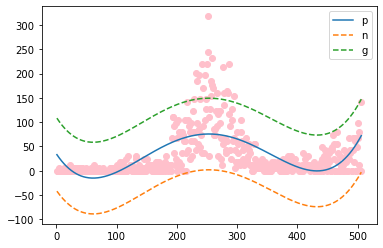

In [139]:
_,upper,lower = wls_prediction_std(poly4)
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day,color='pink')
plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count))
plt.plot(Day_cases_df.Days_Count, upper,'--', label='upper')
plt.plot(Day_cases_df.Days_Count, lower,'--', label='lower')
plt.legend("png")

# FountainCounty Deaths

In [140]:
Day_deaths_df = FountainCounty[['New_deaths_per_day','Days_Count']]
Deaths_LinearModel = smf.ols(formula='New_deaths_per_day~Days_Count', data = Day_deaths_df).fit()
Deaths_Prediction = Deaths_LinearModel.predict(Day_deaths_df.Days_Count)
Deaths_Prediction

211233     0.342985
214375     0.344029
217517     0.345074
220659     0.346118
223801     0.347163
             ...   
1785375    0.866276
1788517    0.867320
1791659    0.868365
1794801    0.869409
1797943    0.870454
Length: 506, dtype: float64

In [141]:
Deaths_LinearModel.params

Intercept     0.341940
Days_Count    0.001044
dtype: float64

In [142]:
New_week_deaths_prediction = Deaths_LinearModel.predict(New_week.Days_Count)
New_week_deaths_prediction

0    0.871498
1    0.872543
2    0.873587
3    0.874632
4    0.875676
5    0.876721
6    0.877765
dtype: float64

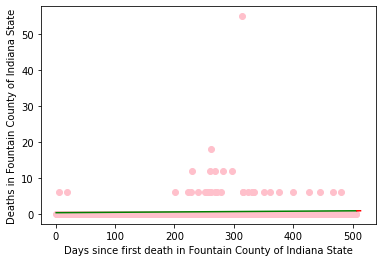

In [143]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, Deaths_Prediction,color='green')
plt.plot(New_week.Days_Count, New_week_deaths_prediction,color='red')
plt.xlabel('Days since first death in Fountain County of Indiana State')
plt.ylabel('Deaths in Fountain County of Indiana State')
plt.show("png")

In [144]:
Deaths_LinearModel.rsquared

0.002390675590813407

In [145]:
sm.rmse(Day_deaths_df.New_deaths_per_day, Deaths_Prediction)

3.1166259892873924

In [146]:
Deaths_LinearModel.pvalues

Intercept     0.219375
Days_Count    0.272295
dtype: float64

In [147]:
Deaths_LinearModel.conf_int()

,0,1
Intercept,-0.204365,0.888246
Days_Count,-0.000823,0.002912


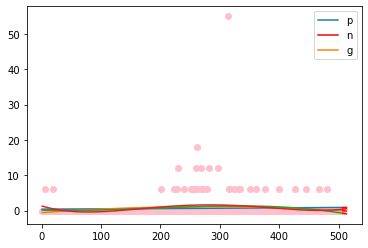

In [148]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color = 'pink')
poly1_d = smf.ols(formula = 'New_deaths_per_day ~ 1+Days_Count', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly1_d.predict(Day_deaths_df.Days_Count), label='poly_1_d')
plt.plot(New_week.Days_Count, poly1_d.predict(New_week.Days_Count), color='red')

poly2_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly2_d.predict(Day_deaths_df.Days_Count), label='poly_2_d')
plt.plot(New_week.Days_Count,poly2_d.predict(New_week.Days_Count), color='red')

poly3_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly3_d.predict(Day_deaths_df.Days_Count), label='poly_3_d')
plt.plot(New_week.Days_Count,poly3_d.predict(New_week.Days_Count), color='red')

poly4_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)',data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly4_d.predict(Day_deaths_df.Days_Count), label='poly_4_d')
plt.plot(New_week.Days_Count, poly4_d.predict(New_week.Days_Count), color='red')

plt.legend("png")

In [149]:
print('R-squared value of poly1_d is: ', poly1_d.rsquared)
print('R-squared value of poly2_d is: ', poly2_d.rsquared)
print('R-squared value of poly3_d is: ', poly3_d.rsquared)
print('R-squared value of poly4_d is: ', poly4_d.rsquared)

R-squared value of poly1_d is:  0.002390675590813407
R-squared value of poly2_d is:  0.02061306572014221
R-squared value of poly3_d is:  0.028067356919119102
R-squared value of poly4_d is:  0.043603380999623464


In [150]:
print('P-values of poly1_d is: ', poly1_d.pvalues)
print('P-values of poly2_d is: ', poly2_d.pvalues)
print('P-values of poly3_d is: ', poly3_d.pvalues)
print('P-values of poly4_d is: ', poly4_d.pvalues)

P-values of poly1_d is:  Intercept     0.219375
Days_Count    0.272295
dtype: float64
P-values of poly2_d is:  Intercept               0.144871
Days_Count              0.001279
I(Days_Count ** 2.0)    0.002338
dtype: float64
P-values of poly3_d is:  Intercept               0.834375
Days_Count              0.614909
I(Days_Count ** 2.0)    0.154920
I(Days_Count ** 3.0)    0.050295
dtype: float64
P-values of poly4_d is:  Intercept               0.058937
Days_Count              0.006636
I(Days_Count ** 2.0)    0.001769
I(Days_Count ** 3.0)    0.002205
I(Days_Count ** 4.0)    0.004513
dtype: float64


In [151]:
print('RMSE of ploy1 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly1.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly2.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly3.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly4.predict(Day_deaths_df.Days_Count)))

RMSE of ploy1 is: 30.26080161672621
RMSE of ploy2 is: 35.37478433558713
RMSE of ploy3 is: 35.53931993464391
RMSE of ploy4 is: 41.4953500571156


In [152]:
poly1_d.conf_int()

,0,1
Intercept,-0.204365,0.888246
Days_Count,-0.000823,0.002912


In [153]:
poly2_d.conf_int()

,0,1
Intercept,-1.420297,0.209231
Days_Count,0.004813,0.019657
I(Days_Count ** 2.0),-0.000036,-0.000008


In [154]:
poly3_d.conf_int()

,0,1
Intercept,-9.713092e-01,1.202811e+00
Days_Count,-2.330305e-02,1.379726e-02
I(Days_Count ** 2.0),-2.336404e-05,1.465890e-04
I(Days_Count ** 3.0),-2.202200e-07,1.418493e-10


In [155]:
poly4_d.conf_int()

,0,1
Intercept,-4.948656e-02,2.661162e+00
Days_Count,-8.824934e-02,-1.432224e-02
I(Days_Count ** 2.0),1.776099e-04,7.697414e-04
I(Days_Count ** 3.0),-2.250461e-06,-4.964998e-07
I(Days_Count ** 4.0),3.878816e-10,2.104113e-09


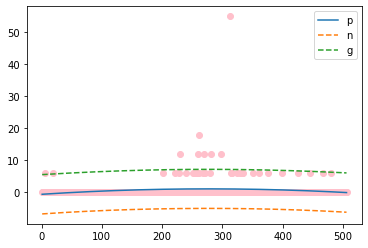

In [156]:
_,upper,lower=wls_prediction_std(poly2_d)
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, poly2_d.predict(Day_deaths_df.Days_Count))
plt.plot(Day_deaths_df.Days_Count, upper,'--',label='upper')
plt.plot(Day_deaths_df.Days_Count, lower,'--',label='lower')
plt.legend("png")

# ClintonCounty

In [157]:
ClintonCounty = ClintonCounty[ClintonCounty['Cases']>0]
ClintonCounty['New_cases_per_day'] = round((ClintonCounty['Cases'].diff()/ClintonCounty['population'])*100000,0)
ClintonCounty['New_deaths_per_day'] = round((ClintonCounty['Deaths'].diff()/ClintonCounty['population'])*100000,0)
ClintonCounty = ClintonCounty.dropna()
ClintonCounty.New_cases_per_day = ClintonCounty.New_cases_per_day.astype(int)
ClintonCounty.New_deaths_per_day = ClintonCounty.New_deaths_per_day.astype(int)

In [158]:
ClintonCounty['Days_Count'] = 0
ClintonCounty['New_cases_per_day'][ClintonCounty['New_cases_per_day']<0]=0
ClintonCounty['New_deaths_per_day'][ClintonCounty['New_deaths_per_day']<0]=0
DaysList=[]
for i in range(0,len(ClintonCounty)):
    count=i+1
    DaysList.append(count)
ClintonCounty['Days_Count'] = DaysList
ClintonCounty

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases,New_cases_per_day,New_deaths_per_day,Days_Count
211222,18023,IN,Clinton County,18,32399,2020-03-29,0,1,0,0,1
214364,18023,IN,Clinton County,18,32399,2020-03-30,0,1,0,0,2
217506,18023,IN,Clinton County,18,32399,2020-03-31,0,1,0,0,3
220648,18023,IN,Clinton County,18,32399,2020-04-01,0,1,0,0,4
223790,18023,IN,Clinton County,18,32399,2020-04-02,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
1785364,18023,IN,Clinton County,18,32399,2021-08-12,63,4770,90,0,502
1788506,18023,IN,Clinton County,18,32399,2021-08-13,64,4781,34,3,503
1791648,18023,IN,Clinton County,18,32399,2021-08-14,64,4781,0,0,504
1794790,18023,IN,Clinton County,18,32399,2021-08-15,64,4781,0,0,505


In [159]:
Day_cases_df = ClintonCounty[['New_cases_per_day','Days_Count']]
Liner_model  = smf.ols(formula='New_cases_per_day~Days_Count', data=Day_cases_df).fit()
Prediction   = Liner_model.predict(Day_cases_df.Days_Count)
Prediction

211222     24.668709
214364     24.687256
217506     24.705803
220648     24.724350
223790     24.742896
             ...    
1785364    33.960661
1788506    33.979208
1791648    33.997754
1794790    34.016301
1797932    34.034848
Length: 506, dtype: float64

In [160]:
New_week=pd.DataFrame({'Days_Count':[507,508,509,510,511, 512, 513]})
New_week

,Days_Count
0,507
1,508
2,509
3,510
4,511
5,512
6,513


In [161]:
New_week_prediction = Liner_model.predict(New_week.Days_Count)
New_week_prediction

0    34.053395
1    34.071942
2    34.090489
3    34.109035
4    34.127582
5    34.146129
6    34.164676
dtype: float64

In [162]:
Liner_model.params

Intercept     24.650162
Days_Count     0.018547
dtype: float64

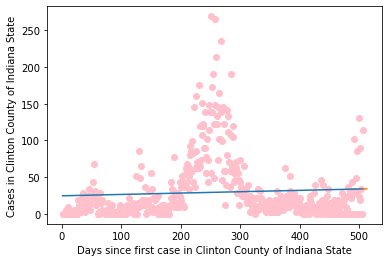

In [163]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day, color='pink')
plt.plot(Day_cases_df.Days_Count, Prediction)
plt.plot(New_week.Days_Count, New_week_prediction)
plt.xlabel('Days since first case in Clinton County of Indiana State')
plt.ylabel('Cases in Clinton County of Indiana State')
plt.show("png")

In [164]:
Liner_model.rsquared

0.004236119726415022

In [165]:
sm.rmse(Day_cases_df.New_cases_per_day, Prediction)

41.53577631939009

In [166]:
Liner_model.pvalues

Intercept     7.557622e-11
Days_Count    1.437436e-01
dtype: float64

In [167]:
Liner_model.conf_int()

,0,1
Intercept,17.369459,31.930866
Days_Count,-0.006338,0.043432


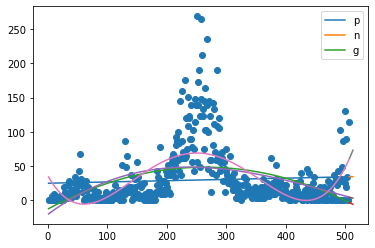

In [168]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
poly1 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly1.predict(Day_cases_df.Days_Count), label = 'poly_1')
plt.plot(New_week.Days_Count, poly1.predict(New_week.Days_Count))

poly2 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly2.predict(Day_cases_df.Days_Count), label = 'poly_2')
plt.plot(New_week.Days_Count, poly2.predict(New_week.Days_Count))

poly3 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly3.predict(Day_cases_df.Days_Count),label = 'poly_3')
plt.plot(New_week.Days_Count, poly3.predict(New_week.Days_Count))

poly4 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count),label = 'poly_4')
plt.plot(New_week.Days_Count, poly4.predict(New_week.Days_Count))

plt.legend("png")

In [169]:
print('R-squared value of poly1 is: ', poly1.rsquared)
print('R-squared value of poly2 is: ', poly2.rsquared)
print('R-squared value of poly3 is: ', poly3.rsquared)
print('R-squared value of poly4 is: ', poly4.rsquared)

R-squared value of poly1 is:  0.004236119726415022
R-squared value of poly2 is:  0.16607912087641186
R-squared value of poly3 is:  0.17109895986502255
R-squared value of poly4 is:  0.36657623979863097


In [170]:
print('P-values of poly1 is: ', poly1.pvalues)
print('P-values of poly2 is: ', poly2.pvalues)
print('P-values of poly3 is: ', poly3.pvalues)
print('P-values of poly4 is: ', poly4.pvalues)

P-values of poly1 is:  Intercept     7.557622e-11
Days_Count    1.437436e-01
dtype: float64
P-values of poly2 is:  Intercept               1.107255e-02
Days_Count              1.792784e-21
I(Days_Count ** 2.0)    3.695897e-21
dtype: float64
P-values of poly3 is:  Intercept               2.271260e-03
Days_Count              3.873290e-08
I(Days_Count ** 2.0)    8.206733e-04
I(Days_Count ** 3.0)    8.184205e-02
dtype: float64
P-values of poly4 is:  Intercept               2.964922e-06
Days_Count              1.459167e-13
I(Days_Count ** 2.0)    1.134911e-24
I(Days_Count ** 3.0)    1.065451e-29
I(Days_Count ** 4.0)    4.001894e-31
dtype: float64


In [171]:
print('RMSE of ploy1 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly1.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly2.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly3.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly4.predict(Day_cases_df.Days_Count)))

RMSE of ploy1 is: 41.53577631939009
RMSE of ploy2 is: 38.01076159323543
RMSE of ploy3 is: 37.89618482680729
RMSE of ploy4 is: 33.127702897517864


In [172]:
poly1.conf_int()

,0,1
Intercept,17.369459,31.930866
Days_Count,-0.006338,0.043432


In [173]:
poly2.conf_int()

,0,1
Intercept,-23.044953,-2.986981
Days_Count,0.372069,0.554776
I(Days_Count ** 2.0),-0.001052,-0.000703


In [174]:
poly3.conf_int()

,0,1
Intercept,-3.430303e+01,-7.520196
Days_Count,4.208663e-01,0.877902
I(Days_Count ** 2.0),-2.840354e-03,-0.000747
I(Days_Count ** 3.0),-1.527513e-07,0.000003


In [175]:
poly4.conf_int()

,0,1
Intercept,2.068647e+01,5.011314e+01
Days_Count,-1.953691e+00,-1.151142e+00
I(Days_Count ** 2.0),1.449002e-02,2.091817e-02
I(Days_Count ** 3.0),-6.809824e-05,-4.905733e-05
I(Days_Count ** 4.0),4.964128e-08,6.827260e-08


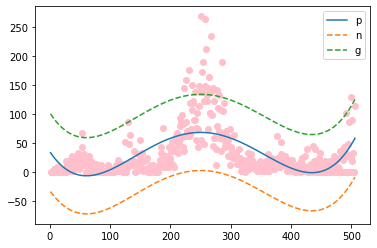

In [176]:
_,upper,lower = wls_prediction_std(poly4)
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day,color='pink')
plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count))
plt.plot(Day_cases_df.Days_Count, upper,'--', label='upper')
plt.plot(Day_cases_df.Days_Count, lower,'--', label='lower')
plt.legend("png")

# Deaths in ClintonCounty

In [177]:
Day_deaths_df = ClintonCounty[['New_deaths_per_day','Days_Count']]
Deaths_LinearModel = smf.ols(formula='New_deaths_per_day~Days_Count', data = Day_deaths_df).fit()
Deaths_Prediction = Deaths_LinearModel.predict(Day_deaths_df.Days_Count)
Deaths_Prediction

211222     0.362818
214364     0.362884
217506     0.362949
220648     0.363015
223790     0.363081
             ...   
1785364    0.395812
1788506    0.395878
1791648    0.395944
1794790    0.396010
1797932    0.396075
Length: 506, dtype: float64

In [178]:
Deaths_LinearModel.params

Intercept     0.362752
Days_Count    0.000066
dtype: float64

In [179]:
New_week_deaths_prediction = Deaths_LinearModel.predict(New_week.Days_Count)
New_week_deaths_prediction

0    0.396141
1    0.396207
2    0.396273
3    0.396339
4    0.396405
5    0.396471
6    0.396536
dtype: float64

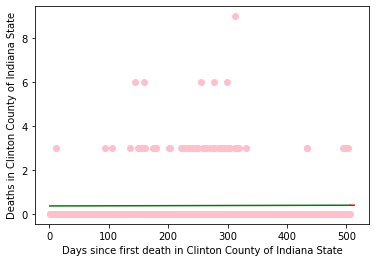

In [180]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, Deaths_Prediction,color='green')
plt.plot(New_week.Days_Count, New_week_deaths_prediction,color='red')
plt.xlabel('Days since first death in Clinton County of Indiana State')
plt.ylabel('Deaths in Clinton County of Indiana State')
plt.show("png")

In [181]:
Deaths_LinearModel.rsquared

7.235493498325418e-05

In [182]:
sm.rmse(Day_deaths_df.New_deaths_per_day, Deaths_Prediction)

1.1308636568328916

In [183]:
Deaths_LinearModel.pvalues

Intercept     0.000356
Days_Count    0.848626
dtype: float64

In [184]:
Deaths_LinearModel.conf_int()

,0,1
Intercept,0.164526,0.560978
Days_Count,-0.000612,0.000743


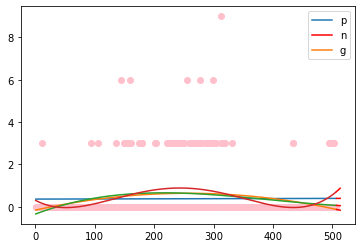

In [185]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color = 'pink')
poly1_d = smf.ols(formula = 'New_deaths_per_day ~ 1+Days_Count', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly1_d.predict(Day_deaths_df.Days_Count), label='poly_1_d')
plt.plot(New_week.Days_Count, poly1_d.predict(New_week.Days_Count), color='red')

poly2_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly2_d.predict(Day_deaths_df.Days_Count), label='poly_2_d')
plt.plot(New_week.Days_Count,poly2_d.predict(New_week.Days_Count), color='red')

poly3_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly3_d.predict(Day_deaths_df.Days_Count), label='poly_3_d')
plt.plot(New_week.Days_Count,poly3_d.predict(New_week.Days_Count), color='red')

poly4_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)',data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly4_d.predict(Day_deaths_df.Days_Count), label='poly_4_d')
plt.plot(New_week.Days_Count, poly4_d.predict(New_week.Days_Count), color='red')

plt.legend("png")

In [186]:
print('R-squared value of poly1_d is: ', poly1_d.rsquared)
print('R-squared value of poly2_d is: ', poly2_d.rsquared)
print('R-squared value of poly3_d is: ', poly3_d.rsquared)
print('R-squared value of poly4_d is: ', poly4_d.rsquared)

R-squared value of poly1_d is:  7.235493498325418e-05
R-squared value of poly2_d is:  0.04219171539835309
R-squared value of poly3_d is:  0.04606373135963038
R-squared value of poly4_d is:  0.08237263014767826


In [187]:
print('P-values of poly1_d is: ', poly1_d.pvalues)
print('P-values of poly2_d is: ', poly2_d.pvalues)
print('P-values of poly3_d is: ', poly3_d.pvalues)
print('P-values of poly4_d is: ', poly4_d.pvalues)

P-values of poly1_d is:  Intercept     0.000356
Days_Count    0.848626
dtype: float64
P-values of poly2_d is:  Intercept               0.284298
Days_Count              0.000005
I(Days_Count ** 2.0)    0.000003
dtype: float64
P-values of poly3_d is:  Intercept               0.080679
Days_Count              0.001746
I(Days_Count ** 2.0)    0.028932
I(Days_Count ** 3.0)    0.154072
dtype: float64
P-values of poly4_d is:  Intercept               0.203741
Days_Count              0.024080
I(Days_Count ** 2.0)    0.000310
I(Days_Count ** 3.0)    0.000027
I(Days_Count ** 4.0)    0.000010
dtype: float64


In [188]:
print('RMSE of ploy1 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly1.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly2.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly3.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly4.predict(Day_deaths_df.Days_Count)))

RMSE of ploy1 is: 29.11979013841109
RMSE of ploy2 is: 33.47524321251464
RMSE of ploy3 is: 33.59872047689747
RMSE of ploy4 is: 38.204950277182924


In [189]:
poly1_d.conf_int()

,0,1
Intercept,0.164526,0.560978
Days_Count,-0.000612,0.000743


In [190]:
poly2_d.conf_int()

,0,1
Intercept,-0.451338,0.132706
Days_Count,0.003572,0.008892
I(Days_Count ** 2.0),-0.000017,-0.000007


In [191]:
poly3_d.conf_int()

,0,1
Intercept,-7.380374e-01,4.259532e-02
Days_Count,4.008861e-03,1.732998e-02
I(Days_Count ** 2.0),-6.453257e-05,-3.509786e-06
I(Days_Count ** 3.0),-1.081809e-08,6.830433e-08


In [192]:
poly4_d.conf_int()

,0,1
Intercept,-1.694878e-01,7.928086e-01
Days_Count,-2.823496e-02,-1.990393e-03
I(Days_Count ** 2.0),8.918214e-05,2.993924e-04
I(Days_Count ** 3.0),-9.826145e-07,-3.599479e-07
I(Days_Count ** 4.0),3.857231e-10,9.949955e-10


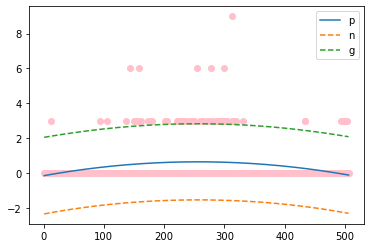

In [193]:
_,upper,lower=wls_prediction_std(poly2_d)
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, poly2_d.predict(Day_deaths_df.Days_Count))
plt.plot(Day_deaths_df.Days_Count, upper,'--',label='upper')
plt.plot(Day_deaths_df.Days_Count, lower,'--',label='lower')
plt.legend("png")

# ElkhartCounty

In [194]:
ElkhartCounty = ElkhartCounty[ElkhartCounty['Cases']>0]
ElkhartCounty['New_cases_per_day'] = round((ElkhartCounty['Cases'].diff()/ElkhartCounty['population'])*100000,0)
ElkhartCounty['New_deaths_per_day'] = round((ElkhartCounty['Deaths'].diff()/ElkhartCounty['population'])*100000,0)
ElkhartCounty = ElkhartCounty.dropna()
ElkhartCounty.New_cases_per_day = ElkhartCounty.New_cases_per_day.astype(int)
ElkhartCounty.New_deaths_per_day = ElkhartCounty.New_deaths_per_day.astype(int)

In [195]:
ElkhartCounty['Days_Count'] = 0
ElkhartCounty['New_cases_per_day'][ElkhartCounty['New_cases_per_day']<0]=0
ElkhartCounty['New_deaths_per_day'][ElkhartCounty['New_deaths_per_day']<0]=0
DaysList=[]
for i in range(0,len(ElkhartCounty)):
    count=i+1
    DaysList.append(count)
ElkhartCounty['Days_Count'] = DaysList
ElkhartCounty

,countyFIPS,State,County Name,StateFIPS,population,Date,Deaths,Cases,New_cases_per_day,New_deaths_per_day,Days_Count
186094,18039,IN,Elkhart County,18,206341,2020-03-21,0,1,0,0,1
189236,18039,IN,Elkhart County,18,206341,2020-03-22,0,1,0,0,2
192378,18039,IN,Elkhart County,18,206341,2020-03-23,0,4,1,0,3
195520,18039,IN,Elkhart County,18,206341,2020-03-24,0,4,0,0,4
198662,18039,IN,Elkhart County,18,206341,2020-03-25,0,5,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
1785372,18039,IN,Elkhart County,18,206341,2021-08-12,490,30318,27,0,510
1788514,18039,IN,Elkhart County,18,206341,2021-08-13,490,30355,18,0,511
1791656,18039,IN,Elkhart County,18,206341,2021-08-14,490,30355,0,0,512
1794798,18039,IN,Elkhart County,18,206341,2021-08-15,490,30355,0,0,513


In [196]:
Day_cases_df = ElkhartCounty[['New_cases_per_day','Days_Count']]
Liner_model  = smf.ols(formula='New_cases_per_day~Days_Count', data=Day_cases_df).fit()
Prediction   = Liner_model.predict(Day_cases_df.Days_Count)
Prediction

186094     32.071331
189236     32.058174
192378     32.045016
195520     32.031859
198662     32.018702
             ...    
1785372    25.374294
1788514    25.361137
1791656    25.347980
1794798    25.334822
1797940    25.321665
Length: 514, dtype: float64

In [197]:
New_week=pd.DataFrame({'Days_Count':[515,516,517,518,519,520,521]})
New_week

,Days_Count
0,515
1,516
2,517
3,518
4,519
5,520
6,521


In [198]:
New_week_prediction = Liner_model.predict(New_week.Days_Count)
New_week_prediction

0    25.308508
1    25.295351
2    25.282193
3    25.269036
4    25.255879
5    25.242722
6    25.229565
dtype: float64

In [199]:
Liner_model.params

Intercept     32.084488
Days_Count    -0.013157
dtype: float64

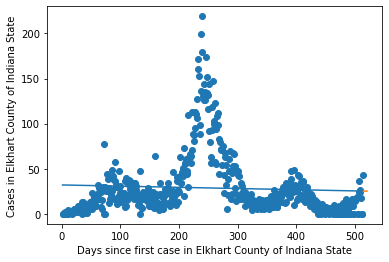

In [200]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
plt.plot(Day_cases_df.Days_Count, Prediction)
plt.plot(New_week.Days_Count, New_week_prediction)
plt.xlabel('Days since first case in Elkhart County of Indiana State')
plt.ylabel('Cases in Elkhart County of Indiana State')
plt.show("png")

In [201]:
Liner_model.rsquared

0.0032721652839001747

In [202]:
sm.rmse(Day_cases_df.New_cases_per_day, Prediction)

34.072754770373905

In [203]:
Liner_model.pvalues

Intercept     5.160715e-24
Days_Count    1.953958e-01
dtype: float64

In [204]:
Liner_model.conf_int()

,0,1
Intercept,26.159163,38.009813
Days_Count,-0.033095,0.006781


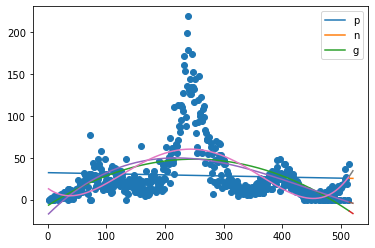

In [205]:
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day)
poly1 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly1.predict(Day_cases_df.Days_Count), label = 'poly_1')
plt.plot(New_week.Days_Count, poly1.predict(New_week.Days_Count))

poly2 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly2.predict(Day_cases_df.Days_Count), label = 'poly_2')
plt.plot(New_week.Days_Count, poly2.predict(New_week.Days_Count))

poly3 = smf.ols(formula='New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly3.predict(Day_cases_df.Days_Count),label = 'poly_3')
plt.plot(New_week.Days_Count, poly3.predict(New_week.Days_Count))

poly4 = smf.ols(formula = 'New_cases_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)', data = Day_cases_df).fit()

plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count),label = 'poly_4')
plt.plot(New_week.Days_Count, poly4.predict(New_week.Days_Count))

plt.legend("png")

In [206]:
print('R-squared value of poly1 is: ', poly1.rsquared)
print('R-squared value of poly2 is: ', poly2.rsquared)
print('R-squared value of poly3 is: ', poly3.rsquared)
print('R-squared value of poly4 is: ', poly4.rsquared)

R-squared value of poly1 is:  0.0032721652839001747
R-squared value of poly2 is:  0.2642990392990445
R-squared value of poly3 is:  0.2782038553433879
R-squared value of poly4 is:  0.3675295636213858


In [207]:
print('P-values of poly1 is: ', poly1.pvalues)
print('P-values of poly2 is: ', poly2.pvalues)
print('P-values of poly3 is: ', poly3.pvalues)
print('P-values of poly4 is: ', poly4.pvalues)

P-values of poly1 is:  Intercept     5.160715e-24
Days_Count    1.953958e-01
dtype: float64
P-values of poly2 is:  Intercept               6.798551e-02
Days_Count              3.740210e-32
I(Days_Count ** 2.0)    1.386688e-35
dtype: float64
P-values of poly3 is:  Intercept               5.831069e-04
Days_Count              1.048286e-14
I(Days_Count ** 2.0)    1.331432e-07
I(Days_Count ** 3.0)    1.820971e-03
dtype: float64
P-values of poly4 is:  Intercept               2.937085e-02
Days_Count              1.962167e-03
I(Days_Count ** 2.0)    1.921912e-10
I(Days_Count ** 3.0)    8.761613e-15
I(Days_Count ** 4.0)    2.480261e-16
dtype: float64


In [208]:
print('RMSE of ploy1 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly1.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly2.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly3.predict(Day_cases_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_cases_df.New_cases_per_day, poly4.predict(Day_cases_df.Days_Count)))

RMSE of ploy1 is: 34.072754770373905
RMSE of ploy2 is: 29.273160629488494
RMSE of ploy3 is: 28.995208314981337
RMSE of ploy4 is: 27.141826454831318


In [209]:
poly1.conf_int()

,0,1
Intercept,26.159163,38.009813
Days_Count,-0.033095,0.006781


In [210]:
poly2.conf_int()

,0,1
Intercept,-14.795290,0.529002
Days_Count,0.374152,0.511572
I(Days_Count ** 2.0),-0.001015,-0.000756


In [211]:
poly3.conf_int()

,0,1
Intercept,-2.806956e+01,-7.741908
Days_Count,5.219114e-01,0.863410
I(Days_Count ** 2.0),-2.866954e-03,-0.001327
I(Days_Count ** 3.0),5.852754e-07,0.000003


In [212]:
poly4.conf_int()

,0,1
Intercept,1.338955e+00,2.525292e+01
Days_Count,-8.295967e-01,-1.875052e-01
I(Days_Count ** 2.0),5.843747e-03,1.090691e-02
I(Days_Count ** 3.0),-3.742502e-05,-2.266023e-05
I(Days_Count ** 4.0),2.357875e-08,3.780150e-08


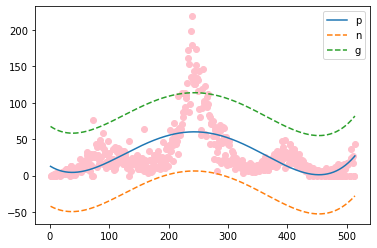

In [213]:
_,upper,lower = wls_prediction_std(poly4)
plt.scatter(Day_cases_df.Days_Count, Day_cases_df.New_cases_per_day,color='pink')
plt.plot(Day_cases_df.Days_Count, poly4.predict(Day_cases_df.Days_Count))
plt.plot(Day_cases_df.Days_Count, upper,'--', label='upper')
plt.plot(Day_cases_df.Days_Count, lower,'--', label='lower')
plt.legend("png")

# ElkhartCounty Deaths

In [214]:
Day_deaths_df = ElkhartCounty[['New_deaths_per_day','Days_Count']]
Deaths_LinearModel = smf.ols(formula='New_deaths_per_day~Days_Count', data = Day_deaths_df).fit()
Deaths_Prediction = Deaths_LinearModel.predict(Day_deaths_df.Days_Count)
Deaths_Prediction

186094     0.351774
189236     0.351646
192378     0.351519
195520     0.351391
198662     0.351264
             ...   
1785372    0.286869
1788514    0.286741
1791656    0.286614
1794798    0.286486
1797940    0.286359
Length: 514, dtype: float64

In [215]:
Deaths_LinearModel.params

Intercept     0.351901
Days_Count   -0.000128
dtype: float64

In [216]:
New_week_deaths_prediction = Deaths_LinearModel.predict(New_week.Days_Count)
New_week_deaths_prediction

0    0.286231
1    0.286104
2    0.285976
3    0.285849
4    0.285721
5    0.285594
6    0.285466
dtype: float64

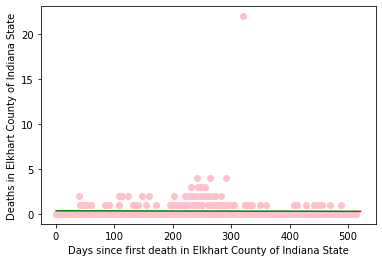

In [217]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, Deaths_Prediction,color='green')
plt.plot(New_week.Days_Count, New_week_deaths_prediction,color='red')
plt.xlabel('Days since first death in Elkhart County of Indiana State')
plt.ylabel('Deaths in Elkhart County of Indiana State')
plt.show("png")

In [218]:
Deaths_LinearModel.rsquared

0.00026913964166697113

In [219]:
sm.rmse(Day_deaths_df.New_deaths_per_day, Deaths_Prediction)

1.153145881717137

In [220]:
Deaths_LinearModel.pvalues

Intercept     0.000612
Days_Count    0.710595
dtype: float64

In [221]:
Deaths_LinearModel.conf_int()

,0,1
Intercept,0.151367,0.552436
Days_Count,-0.000802,0.000547


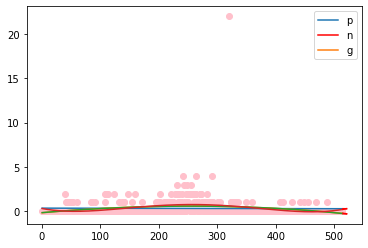

In [222]:
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color = 'pink')
poly1_d = smf.ols(formula = 'New_deaths_per_day ~ 1+Days_Count', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly1_d.predict(Day_deaths_df.Days_Count), label='poly_1_d')
plt.plot(New_week.Days_Count, poly1_d.predict(New_week.Days_Count), color='red')

poly2_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)', data = Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly2_d.predict(Day_deaths_df.Days_Count), label='poly_2_d')
plt.plot(New_week.Days_Count,poly2_d.predict(New_week.Days_Count), color='red')

poly3_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)', data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count,poly3_d.predict(Day_deaths_df.Days_Count), label='poly_3_d')
plt.plot(New_week.Days_Count,poly3_d.predict(New_week.Days_Count), color='red')

poly4_d=smf.ols(formula='New_deaths_per_day ~ 1+Days_Count+I(Days_Count**2.0)+I(Days_Count**3.0)+I(Days_Count**4.0)',data=Day_deaths_df).fit()

plt.plot(Day_deaths_df.Days_Count, poly4_d.predict(Day_deaths_df.Days_Count), label='poly_4_d')
plt.plot(New_week.Days_Count, poly4_d.predict(New_week.Days_Count), color='red')

plt.legend("png")

In [223]:
print('R-squared value of poly1_d is: ', poly1_d.rsquared)
print('R-squared value of poly2_d is: ', poly2_d.rsquared)
print('R-squared value of poly3_d is: ', poly3_d.rsquared)
print('R-squared value of poly4_d is: ', poly4_d.rsquared)

R-squared value of poly1_d is:  0.00026913964166697113
R-squared value of poly2_d is:  0.04160360903068172
R-squared value of poly3_d is:  0.04163939196989863
R-squared value of poly4_d is:  0.05988868876032871


In [224]:
print('P-values of poly1_d is: ', poly1_d.pvalues)
print('P-values of poly2_d is: ', poly2_d.pvalues)
print('P-values of poly3_d is: ', poly3_d.pvalues)
print('P-values of poly4_d is: ', poly4_d.pvalues)

P-values of poly1_d is:  Intercept     0.000612
Days_Count    0.710595
dtype: float64
P-values of poly2_d is:  Intercept               0.243949
Days_Count              0.000010
I(Days_Count ** 2.0)    0.000003
dtype: float64
P-values of poly3_d is:  Intercept               0.436109
Days_Count              0.100010
I(Days_Count ** 2.0)    0.519791
I(Days_Count ** 3.0)    0.890300
dtype: float64
P-values of poly4_d is:  Intercept               0.203068
Days_Count              0.058405
I(Days_Count ** 2.0)    0.004872
I(Days_Count ** 3.0)    0.001811
I(Days_Count ** 4.0)    0.001768
dtype: float64


In [225]:
print('RMSE of ploy1 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly1.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy2 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly2.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy3 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly3.predict(Day_deaths_df.Days_Count)))
print('RMSE of ploy4 is:', sm.rmse(Day_deaths_df.New_deaths_per_day, poly4.predict(Day_deaths_df.Days_Count)))

RMSE of ploy1 is: 28.466579878415843
RMSE of ploy2 is: 33.25964403322687
RMSE of ploy3 is: 33.5030637063033
RMSE of ploy4 is: 34.97599692613769


In [226]:
poly1_d.conf_int()

,0,1
Intercept,0.151367,0.552436
Days_Count,-0.000802,0.000547


In [227]:
poly2_d.conf_int()

,0,1
Intercept,-0.470999,0.120053
Days_Count,0.003355,0.008655
I(Days_Count ** 2.0),-0.000017,-0.000007


In [228]:
poly3_d.conf_int()

,0,1
Intercept,-5.527715e-01,2.387601e-01
Days_Count,-1.072226e-03,1.222526e-02
I(Days_Count ** 2.0),-3.981496e-05,2.015384e-05
I(Days_Count ** 3.0),-4.096227e-08,3.558562e-08


In [229]:
poly4_d.conf_int()

,0,1
Intercept,-1.730481e-01,8.121982e-01
Days_Count,-2.599800e-02,4.559325e-04
I(Days_Count ** 2.0),4.582441e-05,2.544247e-04
I(Days_Count ** 3.0),-7.896704e-07,-1.813667e-07
I(Days_Count ** 4.0),1.757812e-10,7.617533e-10


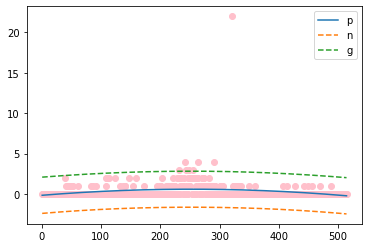

In [230]:
_,upper,lower=wls_prediction_std(poly2_d)
plt.scatter(Day_deaths_df.Days_Count, Day_deaths_df.New_deaths_per_day,color='pink')
plt.plot(Day_deaths_df.Days_Count, poly2_d.predict(Day_deaths_df.Days_Count))
plt.plot(Day_deaths_df.Days_Count, upper,'--',label='upper')
plt.plot(Day_deaths_df.Days_Count, lower,'--',label='lower')
plt.legend("png")

# Hospital Dataset

Reading the hospital dataset to find total available beds in Indiana State's hospitals. Then using this data to find the point of no return.

In [231]:
Hospital_data = pd.read_csv("../../../../data/stage_3/Hospital_Dataset.csv")
Hospital_data = Hospital_data[Hospital_data['state']=='IN']
Hospital_data

,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,...,previous_day_admission_influenza_confirmed,previous_day_admission_influenza_confirmed_coverage,previous_day_deaths_covid_and_influenza,previous_day_deaths_covid_and_influenza_coverage,previous_day_deaths_influenza,previous_day_deaths_influenza_coverage,total_patients_hospitalized_confirmed_influenza,total_patients_hospitalized_confirmed_influenza_and_covid,total_patients_hospitalized_confirmed_influenza_and_covid_coverage,total_patients_hospitalized_confirmed_influenza_coverage
42,IN,23,141,4,23,142,3,0,166,19419,...,1,165,0,165,0,165,8,0,166,165


Total beds in Indiana State's hospitals

In [232]:
Hospital_data['inpatient_beds']

42    19419
Name: inpatient_beds, dtype: int64

Total occupied beds in Indiana State

In [233]:
Hospital_data['inpatient_beds_used']

42    13312
Name: inpatient_beds_used, dtype: int64

Current available hospital bed in Indiana 

In [234]:
Hospital_data['inpatient_beds']-Hospital_data['inpatient_beds_used']

42    6107
dtype: int64

Taking a dataframe for next month and predicting the new cases for that month.

In [235]:
Month = []
for i in range (529, 559):
    Month.append(i)
IN_New_month = pd.DataFrame(Month, columns=['IN_Days_Count'])

In [236]:
IN_New_month_prediction = IN_Liner_model.predict(IN_New_month.IN_Days_Count)
IN_New_month_prediction

0     1897.465808
1     1898.821274
2     1900.176740
3     1901.532206
4     1902.887672
5     1904.243138
6     1905.598604
7     1906.954070
8     1908.309536
9     1909.665002
10    1911.020468
11    1912.375933
12    1913.731399
13    1915.086865
14    1916.442331
15    1917.797797
16    1919.153263
17    1920.508729
18    1921.864195
19    1923.219661
20    1924.575127
21    1925.930593
22    1927.286058
23    1928.641524
24    1929.996990
25    1931.352456
26    1932.707922
27    1934.063388
28    1935.418854
29    1936.774320
dtype: float64

In Indiana state there are 6107 hospital beds available where as the prediction for cases in next month is close to 2000. This states that the the Indiana states is not reaching the point of return in next month.

### Hypothesis Testing

Reading Enrichment dataset from stage one

In [237]:
Emp_data = pd.read_csv("../../../../data/stage_1/Compressed_Employment_Data_Annual_2020.csv")
Emp_data

,countyFIPS,own_code,industry_code,agglvl_code,size_code,year,qtr,disclosure_code,qtrly_estabs,month1_emplvl,...,oty_month3_emplvl_chg,oty_month3_emplvl_pct_chg,oty_total_qtrly_wages_chg,oty_total_qtrly_wages_pct_chg,oty_taxable_qtrly_wages_chg,oty_taxable_qtrly_wages_pct_chg,oty_qtrly_contributions_chg,oty_qtrly_contributions_pct_chg,oty_avg_wkly_wage_chg,oty_avg_wkly_wage_pct_chg
0,1001,5,1021,73,0,2020,1,NaN,191,2137,...,38,1.8,2462818,11.2,924986,8.5,2890,3.0,76,9.4
1,1003,5,1021,73,0,2020,1,NaN,1505,17615,...,41,0.2,5910128,3.8,3149713,3.2,-29954,-3.1,18,2.6
2,1005,5,1021,73,0,2020,1,NaN,139,1383,...,-67,-4.7,-689462,-4.8,-358317,-4.4,-3641,-4.8,-2,-0.3
3,1007,5,1021,73,0,2020,1,NaN,89,937,...,179,22.8,1901579,27.3,1368184,30.3,34911,78.3,29,4.2
4,1009,5,1021,73,0,2020,1,NaN,189,1614,...,-56,-3.4,-354516,-2.3,-353330,-3.6,-7910,-10.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,56037,5,1021,73,0,2020,1,NaN,351,4234,...,-176,-4.1,-2096212,-3.9,-1508021,-3.1,-218430,-43.9,-6,-0.6
3135,56039,5,1021,73,0,2020,1,NaN,337,2564,...,-302,-11.1,1305469,4.7,517130,2.0,-23168,-13.6,117,15.1
3136,56041,5,1021,73,0,2020,1,NaN,163,1698,...,-20,-1.2,554202,3.2,354692,2.2,-73496,-48.8,38,4.9
3137,56043,5,1021,73,0,2020,1,NaN,86,589,...,-43,-6.8,684953,9.1,-112154,-1.8,6752,13.5,154,16.8


In [238]:
Emp_covid_long = pd.merge(Emp_data,superset_long, on = 'countyFIPS')
Emp_covid_long

,countyFIPS,own_code,industry_code,agglvl_code,size_code,year,qtr,disclosure_code,qtrly_estabs,month1_emplvl,...,oty_qtrly_contributions_pct_chg,oty_avg_wkly_wage_chg,oty_avg_wkly_wage_pct_chg,State,County Name,StateFIPS,population,Date,Deaths,Cases
0,1001,5,1021,73,0,2020,1,NaN,191,2137,...,3.0,76,9.4,AL,Autauga County,1,55869,1/22/2020,0,0
1,1001,5,1021,73,0,2020,1,NaN,191,2137,...,3.0,76,9.4,AL,Autauga County,1,55869,1/23/2020,0,0
2,1001,5,1021,73,0,2020,1,NaN,191,2137,...,3.0,76,9.4,AL,Autauga County,1,55869,1/24/2020,0,0
3,1001,5,1021,73,0,2020,1,NaN,191,2137,...,3.0,76,9.4,AL,Autauga County,1,55869,1/25/2020,0,0
4,1001,5,1021,73,0,2020,1,NaN,191,2137,...,3.0,76,9.4,AL,Autauga County,1,55869,1/26/2020,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798642,56045,5,1021,73,0,2020,1,NaN,60,415,...,-21.4,29,4.9,WY,Weston County,56,6927,8/12/2021,6,700
1798643,56045,5,1021,73,0,2020,1,NaN,60,415,...,-21.4,29,4.9,WY,Weston County,56,6927,8/13/2021,6,700
1798644,56045,5,1021,73,0,2020,1,NaN,60,415,...,-21.4,29,4.9,WY,Weston County,56,6927,8/14/2021,6,705
1798645,56045,5,1021,73,0,2020,1,NaN,60,415,...,-21.4,29,4.9,WY,Weston County,56,6927,8/15/2021,6,705


Hypothesis testing to check if Quaterly Establishment is postively related to the cases in Indiana State.

In [239]:
a = Emp_covid_long['qtrly_estabs']
b = Emp_covid_long['Cases']
stats.ttest_ind(a,b, alternative='two-sided')

Ttest_indResult(statistic=-242.49303332597808, pvalue=0.0)

The Pvalues is 0.0 so the null hypothesis rejected for "Quaterly Establishment is positvely related to the cases in Indiana State"

Hypothesis testing to check if Third month of a Quater employment level change is negatively related to the cases in Indiana State.

In [240]:
a = Emp_covid_long['oty_month3_emplvl_chg']
b = Emp_covid_long['Cases']
stats.ttest_ind(a,b, alternative='two-sided')

Ttest_indResult(statistic=-274.72377929422794, pvalue=0.0)

Hypothesis testing to check if Third month of a Quater employment level change is negatively related to the cases in Indiana State.